In [1]:
!source /cvmfs/cms.cern.ch/cmsset_default.sh
!cd /cvmfs/cms.cern.ch/el9_amd64_gcc11/cms/cmssw/CMSSW_13_0_3/src ; eval `scramv1 runtime -sh` ; cd -

import numpy as np
import scipy as sp
import mplhep as hep
import matplotlib.pyplot as plt
import ROOT as r
import copy
r.gROOT.SetBatch(1)
hep.style.use("CMS")
from IPython.display import display, Image
import matplotlib.image as mpimg

/bin/bash: line 1: scramv1: command not found
/eos/home-i02/o/otfische/SWAN_projects/Run3-DisplacedElectronAnalysis/notebooks
Welcome to JupyROOT 6.30/04


In [2]:
#This is only needed if I use getResidualHist
'''r.gStyle.SetOptStat(0)
 
c1 = r.TCanvas("c1", "A ratio example")
h1 = r.TH1D("h1", "h1", 50, 0, 10)
h2 = r.TH1D("h2", "h2", 50, 0, 10)
f1 = r.TF1("f1", "exp(- x/[0] )")
f1.SetParameter(0,3)
 
h1.FillRandom("f1",1900)
h2.FillRandom("f1", 2000)
h1.Sumw2()
h2.Scale(1.9/2.)
 
h1.GetXaxis().SetTitle("x")
h1.GetYaxis().SetTitle("y")
 
rp = r.TRatioPlot(h1,h2)
 
c1.SetTicks(0,1)
rp.GetLowYaxis().SetNdivisions(505)
c1.Update()
c1.Draw()
rp.Draw()'''

'r.gStyle.SetOptStat(0)\n \nc1 = r.TCanvas("c1", "A ratio example")\nh1 = r.TH1D("h1", "h1", 50, 0, 10)\nh2 = r.TH1D("h2", "h2", 50, 0, 10)\nf1 = r.TF1("f1", "exp(- x/[0] )")\nf1.SetParameter(0,3)\n \nh1.FillRandom("f1",1900)\nh2.FillRandom("f1", 2000)\nh1.Sumw2()\nh2.Scale(1.9/2.)\n \nh1.GetXaxis().SetTitle("x")\nh1.GetYaxis().SetTitle("y")\n \nrp = r.TRatioPlot(h1,h2)\n \nc1.SetTicks(0,1)\nrp.GetLowYaxis().SetNdivisions(505)\nc1.Update()\nc1.Draw()\nrp.Draw()'

In [3]:
def getHistogram(dataframe, variable, axis, xlabel = "", selection = ""):
    if selection:
        var_tmp = variable + '_sel'
        rdf_tmp = dataframe.Define(var_tmp, variable + "[(" + selection +")]")
    else:
        var_tmp = variable
        rdf_tmp = dataframe
    hst_tmp = rdf_tmp.Histo1D((var_tmp,";"+ xlabel +";Counts", len(axis)-1, axis), var_tmp)
    return hst_tmp

def getHistogram2d(dataframe, variable, variable2, xaxis, yaxis, xlabel = "", ylabel = "", selection = ""):
    rdf_tmp = dataframe
    if selection:
        var_tmp = variable + '_sel'
        var_tmp2 = variable2 + '_sel'
        rdf_tmp = rdf_tmp.Define(var_tmp, variable + "[(" + selection +")]")
        rdf_tmp = rdf_tmp.Define(var_tmp2, variable2 + "[(" + selection +")]")
    else:
        var_tmp = variable
        var_tmp2 = variable2
        rdf_tmp = dataframe
    hst_tmp = rdf_tmp.Histo2D((var_tmp + var_tmp2,";"+ xlabel +";" + ylabel, len(xaxis)-1, xaxis, len(yaxis)-1, yaxis), var_tmp, var_tmp2)
    return hst_tmp

def getResidualHist(name, histos, axis, eff = False, plotTitle = ""):
    h1 = histos[0].GetValue()
    h2 = histos[1].GetValue()
    maxval = 0
    for value in h1:
        if value>maxval:
            maxval=value
    if maxval>1.0:
        h1.GetYaxis().SetTitle("Density")
    n=0
    total=0
    for value1 in h1:
        for value2 in h2:
            if value2>0:
                tempratio=value1/value2
                n+=1
                total+=tempratio
    averageratio = total/n
    h2.Scale(1)
    h2.SetLineColor(r.kRed)
    h1.Scale(1)
    cRes = r.TCanvas("cRes", "ratio")
    cRes.cd()
    r.gStyle.SetOptStat(0)
    rp = r.TRatioPlot(h1,h2)
    rp.Draw()
    #rp.GetLowerRefGraph().SetMaximum(averageratio)
    rp.GetLowerRefGraph().SetMaximum(1.05)
    rp.GetLowerRefGraph().SetMinimum(0.05)
    rp.GetUpperPad().cd()
    legend = r.TLegend(.75,0.7,1,0.9)
    legend.SetBorderSize(1) 
    legend.SetTextSize(0.040)
    
    if eff:
        legend.AddEntry(h1,"Generated" + plotTitle,"l")
        legend.AddEntry(h2,"Constructed" + plotTitle,"l")
    else:
        legend.AddEntry(h1,"Signal","l")
        legend.AddEntry(h2,"Drell-Yan","l")
    legend.Draw()
    cRes.cd()
    cRes.Update()
    cRes.Draw()
    filen='plots/Dielectron_'+ name +'.png'
    cRes.SaveAs(filen)
    #Image(filename=filen)
    return filen
    
    
def getValues(histo):
    values = []
    for n in range(1, histo.GetNbinsX()+1):
        values.append(histo.GetBinContent(n))
    return np.array(values)

def plotResHistograms(name, histos, bins, labels, isstack, ylog = False, xlog = False):
    hs = []
    colors = [ 'tab:'+c for c in ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']]
    
    hs.append(getValues(histos[0])/getValues(histos[1]))
    fig, ax = plt.subplots(figsize=(10, 8))
    htype = 'fill' if isstack else 'step'
    hep.histplot(
        hs,
        bins=bins,
        histtype=htype,
        color=colors[:len(hs)],
        edgecolor="black" if isstack else colors[:len(hs)],
        label=labels,
        stack=isstack,
        ax=ax,
    )
    hep.cms.label("", data=False, year='2022', com='13.6')
    ax.set_xlabel(histos[0].GetXaxis().GetTitle(), fontsize=22)
    ax.set_ylabel("Residual", fontsize=22)
    if ylog:
        ax.set_yscale('log')
        ax.set_ylim(0.1, 10*max([max(x) for x in hs]))
    if xlog:
        ax.set_xscale('log')
    ax.set_xlim(bins[0], bins[-1])
    legsize = 15 if len(labels)<7 else 10
    ax.legend(fontsize=20)
    fig.savefig('plots/Dielectron'+ name+".png", dpi=140)
    return hep
    
    
def plotHistograms(name, histos, bins, labels, isstack, isnorm, ylog=False, xlog=False):
    hs = []
    colors = [ 'tab:'+c for c in ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']]

    for h in histos:
        if isnorm:
            h.Scale(1./h.Integral())
        hs.append(getValues(h))
    fig, ax = plt.subplots(figsize=(10, 8))
    htype = 'fill' if isstack else 'step'
    hep.histplot(
        hs,
        bins=bins,
        histtype=htype,
        color=colors[:len(hs)],
        edgecolor="black" if isstack else colors[:len(hs)],
        label=labels,
        stack=isstack,
        ax=ax,
    )
    hep.cms.label("", data=False, year='2022', com='13.6')
    ax.set_xlabel(histos[0].GetXaxis().GetTitle(), fontsize=22)
    if isnorm:
        ax.set_ylabel("Density", fontsize=22)
    else:
        ax.set_ylabel("Counts", fontsize=22)
    if ylog:
        ax.set_yscale('log')
        if isnorm:
            ax.set_ylim(0.001, 10*max([max(x) for x in hs]))
        else:
            ax.set_ylim(0.1, 10*max([max(x) for x in hs]))
    if xlog:
        ax.set_xscale('log')
    ax.set_xlim(bins[0], bins[-1])
    legsize = 15 if len(labels)<7 else 10
    ax.legend(fontsize=20)
    fig.savefig('plots/Dielectron'+ name+".png", dpi=140)
    return hep

In [4]:
def histPairVsNot(fileName, plotDataframe, plotVariable, plotAxis, plotxlabel,  plotSelection = ""):
    hists = [0,0]
    if (plotSelection):
        plotSelection = plotSelection + " && "
    hists[0] = getHistogram(dataframe = plotDataframe,
                                     variable = plotVariable,
                                     axis = plotAxis,
                                     xlabel = plotxlabel,
                                     selection = plotSelection) 

    hists[1] = getHistogram(dataframe = plotDataframe,
                                      variable = plotVariable,
                                      axis = plotAxis,
                                      xlabel = plotxlabel,
                                      selection = plotSelection + "lowPtElectron_Lxy_SV > 0") 
    
    plot = plotHistograms(name = fileName, 
               histos = [hists[0], hists[1]], 
               bins = plotAxis, 
               labels = ["No Cut", "Has Valid Vertex"], 
               isstack = False,
               isnorm = True, 
               ylog=False,
               xlog=False)

In [5]:
def fourHistograms(fileName, plotVariable, plotAxis, plotxlabel, Di = True, plotSelection = "", Norm = True):
    hists = [0,0,0,0]
    dataFrames = [signal25mm_rdf,signal250mm_rdf,signal45mm_rdf,signal450mm_rdf]
    if Di:
        dataFrames = [signal25mm_rdf_Di,signal250mm_rdf_Di,signal45mm_rdf_Di,signal450mm_rdf_Di]
        
    hists[0] = getHistogram(dataframe = dataFrames[0],
                                     variable = plotVariable,
                                     axis = plotAxis,
                                     xlabel = plotxlabel,
                                     selection = plotSelection) 

    hists[1] = getHistogram(dataframe = dataFrames[1],
                                      variable = plotVariable,
                                      axis = plotAxis,
                                      xlabel = plotxlabel,
                                     selection = plotSelection) 

    hists[2] = getHistogram(dataframe = dataFrames[2],
                                      variable = plotVariable,
                                      axis = plotAxis,
                                      xlabel = plotxlabel,
                                     selection = plotSelection) 

    hists[3] = getHistogram(dataframe = dataFrames[3],
                                      variable = plotVariable,
                                      axis = plotAxis,
                                      xlabel = plotxlabel,
                                     selection = plotSelection) 


    plot = plotHistograms(name = fileName, 
               histos = [hists[0], hists[1], hists[2], hists[3]], 
               bins = plotAxis, 
               labels = ["Signal 25 mm", "Signal 250 mm", "Signal 45 mm", "Signal 450 mm"], 
               isstack = False,
               isnorm = Norm, 
               ylog=True,
               xlog=False)


    plot = plotHistograms(name = fileName + "25mm&250mm", 
               histos = [hists[0], hists[1]], 
               bins = plotAxis, 
               labels = ["Signal 25 mm", "Signal 250 mm"], 
               isstack = False,
               isnorm = Norm, 
               ylog=True,
               xlog=False)

    plot = plotHistograms(name = fileName + "45mm&450mm", 
               histos = [hists[2], hists[3]], 
               bins = plotAxis, 
               labels = ["Signal 45 mm", "Signal 450 mm"], 
               isstack = False,
               isnorm = Norm, 
               ylog=True,
               xlog=False)
    return hists

In [6]:
def efficiency(fileName, plotVariable, plotAxis, plotxlabel, Di = False, singleVar = False, plotSelection = "", restrictGenPt = False):
    pSelCon = "deltaRGen < 0.2"
    pSelGen ="genParticle_pdgId == 11 || genParticle_pdgId == -11"
    plotVarGen = "genParticle_" + plotVariable
    plotVarCon = "genParticle_" + plotVariable
    #plotVarCon = "lowPtElectron_" + plotVariable
    if (len(plotAxis) == 1):
        plotAxis.append(plotAxis[0])
        plotAxis.append(plotAxis[0])
        plotAxis.append(plotAxis[0])
    if singleVar:
        plotVarGen = "genParticle_" + plotVariable + "_elec"
        pSelCon = ""
        pSelGen = plotSelection
    
    
    if (plotSelection):
        pSelCon = plotSelection + " && " + pSelCon
        pSelGen = plotSelection +" && " + "genParticle_pdgId == 11 || genParticle_pdgId == -11"
    
    if restrictGenPt:
        pSelGen = pSelGen + " && genParticle_pt > 1.0"
        
    histsGen = [0,0,0,0]
    histsCon = [0,0,0,0]
    dataFrames = [signal25mm_rdf,signal250mm_rdf,signal45mm_rdf,signal450mm_rdf]
    signals = ["25 mm", "250 mm", "45 mm", "450 mm"]
    resplots = [0,0,0,0]
    
    if Di:
        dataFrames = [signal25mm_rdf_Di,signal250mm_rdf_Di,signal45mm_rdf_Di,signal450mm_rdf_Di]
    
    
    for i in range(0,4):
        histsGen[i] = getHistogram(dataframe = dataFrames[i],
                                         variable = plotVarGen,
                                         axis = plotAxis[i],
                                         xlabel = signals[i]+ " " + plotxlabel,
                                         selection = pSelGen) 

        histsCon[i] = getHistogram(dataframe = dataFrames[i],
                                         variable = plotVarCon,
                                         axis = plotAxis[i],
                                         xlabel = signals[i]+ " " + plotxlabel,
                                         selection = pSelCon) 
        
        plot = plotHistograms(name = fileName + signals[i], 
                       histos = [histsGen[i], histsCon[i]], 
                       bins = plotAxis[i], 
                       labels = ["Generated " + signals[i], "Constructed " + signals[i]], 
                       isstack = False,
                       isnorm = False, 
                       ylog=False,
                       xlog=False)
        print(histsCon[i].GetValue())
        print(histsGen[i].GetValue())
        if (r.TEfficiency.CheckConsistency(histsCon[i].GetValue(), histsGen[i].GetValue())):
            resplots[i] = r.TEfficiency(histsCon[i].GetValue(), histsGen[i].GetValue())
            with r.TFile("myfile.root", "RECREATE") as pFile:
                resplots[i].Write()
        else:
            resplots[i] = plotResHistograms(name =  fileName + signals[i], 
                           histos = [histsCon[i], histsGen[i]], 
                           bins = plotAxis[i], 
                           labels = [signals[i]], 
                           isstack = False,
                           ylog=False,
                           xlog=False)
    return resplots

In [7]:
## Signal samples:
signal25mm_rdf = r.RDataFrame("Events", "/eos/user/f/fernance/standard-TutoriasFiles/SquarkToNeutralinoTo2LNu-MSquark_350_MChi_150_ctau_25mm.root")
signal250mm_rdf = r.RDataFrame("Events", "/eos/user/f/fernance/standard-TutoriasFiles/SquarkToNeutralinoTo2LNu-MSquark_350_MChi_150_ctau_250mm.root")
signal45mm_rdf = r.RDataFrame("Events", "/eos/user/f/fernance/standard-TutoriasFiles/SquarkToNeutralinoTo2LNu-MSquark_350_MChi_325_ctau_45mm.root")
signal450mm_rdf = r.RDataFrame("Events", "/eos/user/f/fernance/standard-TutoriasFiles/SquarkToNeutralinoTo2LNu-MSquark_350_MChi_325_ctau_450mm.root")

## Background samples:
#dy_rdf = r.RDataFrame("Events", "/eos/user/f/fernance/standard-TutoriasFiles/background_DYJetsToLL_M-50.root")

## Test_sample:
#test_rdf = r.RDataFrame("Events", "/eos/user/o/otfische/CMSSW_13_3_0/src/Analysis/Run3-DisplacedElectronAnalysis/output.root")

In [8]:
signal25mm_rdf = signal25mm_rdf.Define("Delta_Dxy","abs(lowPtElectron_dB[0]-lowPtElectron_dB[1])")
signal250mm_rdf = signal250mm_rdf.Define("Delta_Dxy","abs(lowPtElectron_dB[0]-lowPtElectron_dB[1])")
signal25mm_rdf = signal25mm_rdf.Define("Delta_eta","abs(lowPtElectron_eta[0]-lowPtElectron_eta[1])")
signal250mm_rdf = signal250mm_rdf.Define("Delta_eta","abs(lowPtElectron_eta[0]-lowPtElectron_eta[1])")
signal25mm_rdf = signal25mm_rdf.Define("Dielectron_mass","sqrt(2*lowPtElectron_pt[0]*lowPtElectron_pt[1]*(cosh(lowPtElectron_eta[0] - lowPtElectron_eta[1]) - cos(lowPtElectron_phi[0] - lowPtElectron_phi[1])))")
signal250mm_rdf = signal250mm_rdf.Define("Dielectron_mass","sqrt(2*lowPtElectron_pt[0]*lowPtElectron_pt[1]*(cosh(lowPtElectron_eta[0] - lowPtElectron_eta[1]) - cos(lowPtElectron_phi[0] - lowPtElectron_phi[1])))")
signal25mm_rdf = signal25mm_rdf.Define('Delta_R',"sqrt((lowPtElectron_eta[0]-lowPtElectron_eta[1])*(lowPtElectron_eta[0]-lowPtElectron_eta[1])-(lowPtElectron_phi[0]-lowPtElectron_phi[1])*(lowPtElectron_phi[0]-lowPtElectron_phi[1]))")
signal250mm_rdf = signal250mm_rdf.Define('Delta_R',"sqrt((lowPtElectron_eta[0]-lowPtElectron_eta[1])*(lowPtElectron_eta[0]-lowPtElectron_eta[1])-(lowPtElectron_phi[0]-lowPtElectron_phi[1])*(lowPtElectron_phi[0]-lowPtElectron_phi[1]))")

signal25mm_rdf = signal25mm_rdf.Define("dBSig","lowPtElectron_dB/lowPtElectron_edB")
signal250mm_rdf = signal250mm_rdf.Define("dBSig","lowPtElectron_dB/lowPtElectron_edB")

signal45mm_rdf = signal45mm_rdf.Define("Delta_Dxy","abs(lowPtElectron_dB[0]-lowPtElectron_dB[1])")
signal450mm_rdf = signal450mm_rdf.Define("Delta_Dxy","abs(lowPtElectron_dB[0]-lowPtElectron_dB[1])")
signal45mm_rdf = signal45mm_rdf.Define("Delta_eta","abs(lowPtElectron_eta[0]-lowPtElectron_eta[1])")
signal450mm_rdf = signal450mm_rdf.Define("Delta_eta","abs(lowPtElectron_eta[0]-lowPtElectron_eta[1])")
signal45mm_rdf = signal45mm_rdf.Define("Dielectron_mass","sqrt(2*lowPtElectron_pt[0]*lowPtElectron_pt[1]*(cosh(lowPtElectron_eta[0] - lowPtElectron_eta[1]) - cos(lowPtElectron_phi[0] - lowPtElectron_phi[1])))")
signal450mm_rdf = signal450mm_rdf.Define("Dielectron_mass","sqrt(2*lowPtElectron_pt[0]*lowPtElectron_pt[1]*(cosh(lowPtElectron_eta[0] - lowPtElectron_eta[1]) - cos(lowPtElectron_phi[0] - lowPtElectron_phi[1])))")
signal45mm_rdf = signal45mm_rdf.Define('Delta_R',"sqrt((lowPtElectron_eta[0]-lowPtElectron_eta[1])*(lowPtElectron_eta[0]-lowPtElectron_eta[1])-(lowPtElectron_phi[0]-lowPtElectron_phi[1])*(lowPtElectron_phi[0]-lowPtElectron_phi[1]))")
signal450mm_rdf = signal450mm_rdf.Define('Delta_R',"sqrt((lowPtElectron_eta[0]-lowPtElectron_eta[1])*(lowPtElectron_eta[0]-lowPtElectron_eta[1])-(lowPtElectron_phi[0]-lowPtElectron_phi[1])*(lowPtElectron_phi[0]-lowPtElectron_phi[1]))")

#3D angle calculations:
#Low Pt Electrons:
signal25mm_rdf = signal25mm_rdf.Define('lowPtElectron_px0', 'lowPtElectron_pt[0]*cos(lowPtElectron_phi[0])')
signal25mm_rdf = signal25mm_rdf.Define('lowPtElectron_py0', 'lowPtElectron_pt[0]*sin(lowPtElectron_phi[0])')
signal25mm_rdf = signal25mm_rdf.Define('lowPtElectron_pz0', 'lowPtElectron_pt[0]*sinh(lowPtElectron_eta[0])')
signal25mm_rdf = signal25mm_rdf.Define('lowPtElectron_px1', 'lowPtElectron_pt[0]*cos(lowPtElectron_phi[1])')
signal25mm_rdf = signal25mm_rdf.Define('lowPtElectron_py1', 'lowPtElectron_pt[0]*sin(lowPtElectron_phi[1])')
signal25mm_rdf = signal25mm_rdf.Define('lowPtElectron_pz1', 'lowPtElectron_pt[0]*sinh(lowPtElectron_eta[1])')
signal25mm_rdf = signal25mm_rdf.Define('lowPtElectron_3d_angle', 'acos((lowPtElectron_px0*lowPtElectron_px1+lowPtElectron_py0*lowPtElectron_py1+lowPtElectron_pz0*lowPtElectron_pz1)/(sqrt(lowPtElectron_px0*lowPtElectron_px0+lowPtElectron_pz0*lowPtElectron_pz0+lowPtElectron_py0*lowPtElectron_py0)*sqrt(lowPtElectron_px1*lowPtElectron_px1+lowPtElectron_pz1*lowPtElectron_pz1+lowPtElectron_py1*lowPtElectron_py1)))')

signal250mm_rdf = signal250mm_rdf.Define('lowPtElectron_px0', 'lowPtElectron_pt[0]*cos(lowPtElectron_phi[0])')
signal250mm_rdf = signal250mm_rdf.Define('lowPtElectron_py0', 'lowPtElectron_pt[0]*sin(lowPtElectron_phi[0])')
signal250mm_rdf = signal250mm_rdf.Define('lowPtElectron_pz0', 'lowPtElectron_pt[0]*sinh(lowPtElectron_eta[0])')
signal250mm_rdf = signal250mm_rdf.Define('lowPtElectron_px1', 'lowPtElectron_pt[0]*cos(lowPtElectron_phi[1])')
signal250mm_rdf = signal250mm_rdf.Define('lowPtElectron_py1', 'lowPtElectron_pt[0]*sin(lowPtElectron_phi[1])')
signal250mm_rdf = signal250mm_rdf.Define('lowPtElectron_pz1', 'lowPtElectron_pt[0]*sinh(lowPtElectron_eta[1])')
signal250mm_rdf = signal250mm_rdf.Define('lowPtElectron_3d_angle', 'acos((lowPtElectron_px0*lowPtElectron_px1+lowPtElectron_py0*lowPtElectron_py1+lowPtElectron_pz0*lowPtElectron_pz1)/(sqrt(lowPtElectron_px0*lowPtElectron_px0+lowPtElectron_pz0*lowPtElectron_pz0+lowPtElectron_py0*lowPtElectron_py0)*sqrt(lowPtElectron_px1*lowPtElectron_px1+lowPtElectron_pz1*lowPtElectron_pz1+lowPtElectron_py1*lowPtElectron_py1)))')

signal45mm_rdf = signal45mm_rdf.Define('lowPtElectron_px0', 'lowPtElectron_pt[0]*cos(lowPtElectron_phi[0])')
signal45mm_rdf = signal45mm_rdf.Define('lowPtElectron_py0', 'lowPtElectron_pt[0]*sin(lowPtElectron_phi[0])')
signal45mm_rdf = signal45mm_rdf.Define('lowPtElectron_pz0', 'lowPtElectron_pt[0]*sinh(lowPtElectron_eta[0])')
signal45mm_rdf = signal45mm_rdf.Define('lowPtElectron_px1', 'lowPtElectron_pt[0]*cos(lowPtElectron_phi[1])')
signal45mm_rdf = signal45mm_rdf.Define('lowPtElectron_py1', 'lowPtElectron_pt[0]*sin(lowPtElectron_phi[1])')
signal45mm_rdf = signal45mm_rdf.Define('lowPtElectron_pz1', 'lowPtElectron_pt[0]*sinh(lowPtElectron_eta[1])')
signal45mm_rdf = signal45mm_rdf.Define('lowPtElectron_3d_angle', 'acos((lowPtElectron_px0*lowPtElectron_px1+lowPtElectron_py0*lowPtElectron_py1+lowPtElectron_pz0*lowPtElectron_pz1)/(sqrt(lowPtElectron_px0*lowPtElectron_px0+lowPtElectron_pz0*lowPtElectron_pz0+lowPtElectron_py0*lowPtElectron_py0)*sqrt(lowPtElectron_px1*lowPtElectron_px1+lowPtElectron_pz1*lowPtElectron_pz1+lowPtElectron_py1*lowPtElectron_py1)))')

signal450mm_rdf = signal450mm_rdf.Define('lowPtElectron_px0', 'lowPtElectron_pt[0]*cos(lowPtElectron_phi[0])')
signal450mm_rdf = signal450mm_rdf.Define('lowPtElectron_py0', 'lowPtElectron_pt[0]*sin(lowPtElectron_phi[0])')
signal450mm_rdf = signal450mm_rdf.Define('lowPtElectron_pz0', 'lowPtElectron_pt[0]*sinh(lowPtElectron_eta[0])')
signal450mm_rdf = signal450mm_rdf.Define('lowPtElectron_px1', 'lowPtElectron_pt[0]*cos(lowPtElectron_phi[1])')
signal450mm_rdf = signal450mm_rdf.Define('lowPtElectron_py1', 'lowPtElectron_pt[0]*sin(lowPtElectron_phi[1])')
signal450mm_rdf = signal450mm_rdf.Define('lowPtElectron_pz1', 'lowPtElectron_pt[0]*sinh(lowPtElectron_eta[1])')
signal450mm_rdf = signal450mm_rdf.Define('lowPtElectron_3d_angle', 'acos((lowPtElectron_px0*lowPtElectron_px1+lowPtElectron_py0*lowPtElectron_py1+lowPtElectron_pz0*lowPtElectron_pz1)/(sqrt(lowPtElectron_px0*lowPtElectron_px0+lowPtElectron_pz0*lowPtElectron_pz0+lowPtElectron_py0*lowPtElectron_py0)*sqrt(lowPtElectron_px1*lowPtElectron_px1+lowPtElectron_pz1*lowPtElectron_pz1+lowPtElectron_py1*lowPtElectron_py1)))')

#Generated Particles:

signal25mm_rdf = signal25mm_rdf.Define('genParticle_px0', 'genParticle_pt[0]*cos(genParticle_phi[0])')
signal25mm_rdf = signal25mm_rdf.Define('genParticle_py0', 'genParticle_pt[0]*sin(genParticle_phi[0])')
signal25mm_rdf = signal25mm_rdf.Define('genParticle_pz0', 'genParticle_pt[0]*sinh(genParticle_eta[0])')
signal25mm_rdf = signal25mm_rdf.Define('genParticle_px1', 'genParticle_pt[0]*cos(genParticle_phi[1])')
signal25mm_rdf = signal25mm_rdf.Define('genParticle_py1', 'genParticle_pt[0]*sin(genParticle_phi[1])')
signal25mm_rdf = signal25mm_rdf.Define('genParticle_pz1', 'genParticle_pt[0]*sinh(genParticle_eta[1])')
signal25mm_rdf = signal25mm_rdf.Define('genParticle_3d_angle', 'acos((genParticle_px0*genParticle_px1+genParticle_py0*genParticle_py1+genParticle_pz0*genParticle_pz1)/(sqrt(genParticle_px0*genParticle_px0+genParticle_pz0*genParticle_pz0+genParticle_py0*genParticle_py0)*sqrt(genParticle_px1*genParticle_px1+genParticle_pz1*genParticle_pz1+genParticle_py1*genParticle_py1)))')

signal250mm_rdf = signal250mm_rdf.Define('genParticle_px0', 'genParticle_pt[0]*cos(genParticle_phi[0])')
signal250mm_rdf = signal250mm_rdf.Define('genParticle_py0', 'genParticle_pt[0]*sin(genParticle_phi[0])')
signal250mm_rdf = signal250mm_rdf.Define('genParticle_pz0', 'genParticle_pt[0]*sinh(genParticle_eta[0])')
signal250mm_rdf = signal250mm_rdf.Define('genParticle_px1', 'genParticle_pt[0]*cos(genParticle_phi[1])')
signal250mm_rdf = signal250mm_rdf.Define('genParticle_py1', 'genParticle_pt[0]*sin(genParticle_phi[1])')
signal250mm_rdf = signal250mm_rdf.Define('genParticle_pz1', 'genParticle_pt[0]*sinh(genParticle_eta[1])')
signal250mm_rdf = signal250mm_rdf.Define('genParticle_3d_angle', 'acos((genParticle_px0*genParticle_px1+genParticle_py0*genParticle_py1+genParticle_pz0*genParticle_pz1)/(sqrt(genParticle_px0*genParticle_px0+genParticle_pz0*genParticle_pz0+genParticle_py0*genParticle_py0)*sqrt(genParticle_px1*genParticle_px1+genParticle_pz1*genParticle_pz1+genParticle_py1*genParticle_py1)))')

signal45mm_rdf = signal45mm_rdf.Define('genParticle_px0', 'genParticle_pt[0]*cos(genParticle_phi[0])')
signal45mm_rdf = signal45mm_rdf.Define('genParticle_py0', 'genParticle_pt[0]*sin(genParticle_phi[0])')
signal45mm_rdf = signal45mm_rdf.Define('genParticle_pz0', 'genParticle_pt[0]*sinh(genParticle_eta[0])')
signal45mm_rdf = signal45mm_rdf.Define('genParticle_px1', 'genParticle_pt[0]*cos(genParticle_phi[1])')
signal45mm_rdf = signal45mm_rdf.Define('genParticle_py1', 'genParticle_pt[0]*sin(genParticle_phi[1])')
signal45mm_rdf = signal45mm_rdf.Define('genParticle_pz1', 'genParticle_pt[0]*sinh(genParticle_eta[1])')
signal45mm_rdf = signal45mm_rdf.Define('genParticle_3d_angle', 'acos((genParticle_px0*genParticle_px1+genParticle_py0*genParticle_py1+genParticle_pz0*genParticle_pz1)/(sqrt(genParticle_px0*genParticle_px0+genParticle_pz0*genParticle_pz0+genParticle_py0*genParticle_py0)*sqrt(genParticle_px1*genParticle_px1+genParticle_pz1*genParticle_pz1+genParticle_py1*genParticle_py1)))')

signal450mm_rdf = signal450mm_rdf.Define('genParticle_px0', 'genParticle_pt[0]*cos(genParticle_phi[0])')
signal450mm_rdf = signal450mm_rdf.Define('genParticle_py0', 'genParticle_pt[0]*sin(genParticle_phi[0])')
signal450mm_rdf = signal450mm_rdf.Define('genParticle_pz0', 'genParticle_pt[0]*sinh(genParticle_eta[0])')
signal450mm_rdf = signal450mm_rdf.Define('genParticle_px1', 'genParticle_pt[0]*cos(genParticle_phi[1])')
signal450mm_rdf = signal450mm_rdf.Define('genParticle_py1', 'genParticle_pt[0]*sin(genParticle_phi[1])')
signal450mm_rdf = signal450mm_rdf.Define('genParticle_pz1', 'genParticle_pt[0]*sinh(genParticle_eta[1])')
signal450mm_rdf = signal450mm_rdf.Define('genParticle_3d_angle', 'acos((genParticle_px0*genParticle_px1+genParticle_py0*genParticle_py1+genParticle_pz0*genParticle_pz1)/(sqrt(genParticle_px0*genParticle_px0+genParticle_pz0*genParticle_pz0+genParticle_py0*genParticle_py0)*sqrt(genParticle_px1*genParticle_px1+genParticle_pz1*genParticle_pz1+genParticle_py1*genParticle_py1)))')


signal45mm_rdf = signal45mm_rdf.Define("dBSig","lowPtElectron_dB/lowPtElectron_edB")
signal450mm_rdf = signal450mm_rdf.Define("dBSig","lowPtElectron_dB/lowPtElectron_edB")

In [9]:
signal25mm_rdf = signal25mm_rdf.Define("genParticle_eta_elec","ROOT::VecOps::RVec<float> eta_values; for (size_t i = 0; i < genParticle_eta.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { eta_values.push_back(genParticle_eta[i]); } } return eta_values;")
signal25mm_rdf = signal25mm_rdf.Define("genParticle_index_elec","ROOT::VecOps::RVec<int> indices; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { indices.push_back(genParticle_index[i]); } } return indices;");
signal25mm_rdf = signal25mm_rdf.Define("genParticle_lxy_elec","ROOT::VecOps::RVec<float> lxy; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { lxy.push_back(genParticle_lxy[i]); } } return lxy;");
signal25mm_rdf = signal25mm_rdf.Define("genParticle_m_elec","ROOT::VecOps::RVec<float> masses; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { masses.push_back(genParticle_m[i]); } } return masses;");
signal25mm_rdf = signal25mm_rdf.Define("genParticle_motherIndex_elec","ROOT::VecOps::RVec<int> motherIndices; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { motherIndices.push_back(genParticle_motherIndex[i]); } } return motherIndices;");
signal25mm_rdf = signal25mm_rdf.Define("genParticle_motherPdgId_elec","ROOT::VecOps::RVec<int> motherPdgIds; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { motherPdgIds.push_back(genParticle_motherPdgId[i]); } } return motherPdgIds;");
signal25mm_rdf = signal25mm_rdf.Define("genParticle_phi_elec","ROOT::VecOps::RVec<float> phis; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { phis.push_back(genParticle_phi[i]); } } return phis;");
signal25mm_rdf = signal25mm_rdf.Define("genParticle_pt_elec","ROOT::VecOps::RVec<float> pts; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { pts.push_back(genParticle_pt[i]); } } return pts;");
signal25mm_rdf = signal25mm_rdf.Define("genParticle_status_elec","ROOT::VecOps::RVec<int> statuses; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { statuses.push_back(genParticle_status[i]); } } return statuses;");
signal25mm_rdf = signal25mm_rdf.Define("genParticle_vx_elec","ROOT::VecOps::RVec<float> vx; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { vx.push_back(genParticle_vx[i]); } } return vx;");
signal25mm_rdf = signal25mm_rdf.Define("genParticle_vy_elec","ROOT::VecOps::RVec<float> vy; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { vy.push_back(genParticle_vy[i]); } } return vy;");
signal25mm_rdf = signal25mm_rdf.Define("genParticle_vz_elec","ROOT::VecOps::RVec<float> vz; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { vz.push_back(genParticle_vz[i]); } } return vz;");

signal250mm_rdf = signal250mm_rdf.Define("genParticle_eta_elec","ROOT::VecOps::RVec<float> eta_values; for (size_t i = 0; i < genParticle_eta.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { eta_values.push_back(genParticle_eta[i]); } } return eta_values;")
signal250mm_rdf = signal250mm_rdf.Define("genParticle_index_elec","ROOT::VecOps::RVec<int> indices; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { indices.push_back(genParticle_index[i]); } } return indices;");
signal250mm_rdf = signal250mm_rdf.Define("genParticle_lxy_elec","ROOT::VecOps::RVec<float> lxy; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { lxy.push_back(genParticle_lxy[i]); } } return lxy;");
signal250mm_rdf = signal250mm_rdf.Define("genParticle_m_elec","ROOT::VecOps::RVec<float> masses; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { masses.push_back(genParticle_m[i]); } } return masses;");
signal250mm_rdf = signal250mm_rdf.Define("genParticle_motherIndex_elec","ROOT::VecOps::RVec<int> motherIndices; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { motherIndices.push_back(genParticle_motherIndex[i]); } } return motherIndices;");
signal250mm_rdf = signal250mm_rdf.Define("genParticle_motherPdgId_elec","ROOT::VecOps::RVec<int> motherPdgIds; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { motherPdgIds.push_back(genParticle_motherPdgId[i]); } } return motherPdgIds;");
signal250mm_rdf = signal250mm_rdf.Define("genParticle_phi_elec","ROOT::VecOps::RVec<float> phis; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { phis.push_back(genParticle_phi[i]); } } return phis;");
signal250mm_rdf = signal250mm_rdf.Define("genParticle_pt_elec","ROOT::VecOps::RVec<float> pts; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { pts.push_back(genParticle_pt[i]); } } return pts;");
signal250mm_rdf = signal250mm_rdf.Define("genParticle_status_elec","ROOT::VecOps::RVec<int> statuses; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { statuses.push_back(genParticle_status[i]); } } return statuses;");
signal250mm_rdf = signal250mm_rdf.Define("genParticle_vx_elec","ROOT::VecOps::RVec<float> vx; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { vx.push_back(genParticle_vx[i]); } } return vx;");
signal250mm_rdf = signal250mm_rdf.Define("genParticle_vy_elec","ROOT::VecOps::RVec<float> vy; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { vy.push_back(genParticle_vy[i]); } } return vy;");
signal250mm_rdf = signal250mm_rdf.Define("genParticle_vz_elec","ROOT::VecOps::RVec<float> vz; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { vz.push_back(genParticle_vz[i]); } } return vz;");

signal45mm_rdf = signal45mm_rdf.Define("genParticle_eta_elec","ROOT::VecOps::RVec<float> eta_values; for (size_t i = 0; i < genParticle_eta.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { eta_values.push_back(genParticle_eta[i]); } } return eta_values;")
signal45mm_rdf = signal45mm_rdf.Define("genParticle_index_elec","ROOT::VecOps::RVec<int> indices; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { indices.push_back(genParticle_index[i]); } } return indices;");
signal45mm_rdf = signal45mm_rdf.Define("genParticle_lxy_elec","ROOT::VecOps::RVec<float> lxy; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { lxy.push_back(genParticle_lxy[i]); } } return lxy;");
signal45mm_rdf = signal45mm_rdf.Define("genParticle_m_elec","ROOT::VecOps::RVec<float> masses; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { masses.push_back(genParticle_m[i]); } } return masses;");
signal45mm_rdf = signal45mm_rdf.Define("genParticle_motherIndex_elec","ROOT::VecOps::RVec<int> motherIndices; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { motherIndices.push_back(genParticle_motherIndex[i]); } } return motherIndices;");
signal45mm_rdf = signal45mm_rdf.Define("genParticle_motherPdgId_elec","ROOT::VecOps::RVec<int> motherPdgIds; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { motherPdgIds.push_back(genParticle_motherPdgId[i]); } } return motherPdgIds;");
signal45mm_rdf = signal45mm_rdf.Define("genParticle_phi_elec","ROOT::VecOps::RVec<float> phis; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { phis.push_back(genParticle_phi[i]); } } return phis;");
signal45mm_rdf = signal45mm_rdf.Define("genParticle_pt_elec","ROOT::VecOps::RVec<float> pts; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { pts.push_back(genParticle_pt[i]); } } return pts;");
signal45mm_rdf = signal45mm_rdf.Define("genParticle_status_elec","ROOT::VecOps::RVec<int> statuses; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { statuses.push_back(genParticle_status[i]); } } return statuses;");
signal45mm_rdf = signal45mm_rdf.Define("genParticle_vx_elec","ROOT::VecOps::RVec<float> vx; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { vx.push_back(genParticle_vx[i]); } } return vx;");
signal45mm_rdf = signal45mm_rdf.Define("genParticle_vy_elec","ROOT::VecOps::RVec<float> vy; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { vy.push_back(genParticle_vy[i]); } } return vy;");
signal45mm_rdf = signal45mm_rdf.Define("genParticle_vz_elec","ROOT::VecOps::RVec<float> vz; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { vz.push_back(genParticle_vz[i]); } } return vz;");

signal450mm_rdf = signal450mm_rdf.Define("genParticle_eta_elec","ROOT::VecOps::RVec<float> eta_values; for (size_t i = 0; i < genParticle_eta.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { eta_values.push_back(genParticle_eta[i]); } } return eta_values;")
signal450mm_rdf = signal450mm_rdf.Define("genParticle_index_elec","ROOT::VecOps::RVec<int> indices; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { indices.push_back(genParticle_index[i]); } } return indices;");
signal450mm_rdf = signal450mm_rdf.Define("genParticle_lxy_elec","ROOT::VecOps::RVec<float> lxy; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { lxy.push_back(genParticle_lxy[i]); } } return lxy;");
signal450mm_rdf = signal450mm_rdf.Define("genParticle_m_elec","ROOT::VecOps::RVec<float> masses; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { masses.push_back(genParticle_m[i]); } } return masses;");
signal450mm_rdf = signal450mm_rdf.Define("genParticle_motherIndex_elec","ROOT::VecOps::RVec<int> motherIndices; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { motherIndices.push_back(genParticle_motherIndex[i]); } } return motherIndices;");
signal450mm_rdf = signal450mm_rdf.Define("genParticle_motherPdgId_elec","ROOT::VecOps::RVec<int> motherPdgIds; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { motherPdgIds.push_back(genParticle_motherPdgId[i]); } } return motherPdgIds;");
signal450mm_rdf = signal450mm_rdf.Define("genParticle_phi_elec","ROOT::VecOps::RVec<float> phis; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { phis.push_back(genParticle_phi[i]); } } return phis;");
signal450mm_rdf = signal450mm_rdf.Define("genParticle_pt_elec","ROOT::VecOps::RVec<float> pts; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { pts.push_back(genParticle_pt[i]); } } return pts;");
signal450mm_rdf = signal450mm_rdf.Define("genParticle_status_elec","ROOT::VecOps::RVec<int> statuses; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { statuses.push_back(genParticle_status[i]); } } return statuses;");
signal450mm_rdf = signal450mm_rdf.Define("genParticle_vx_elec","ROOT::VecOps::RVec<float> vx; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { vx.push_back(genParticle_vx[i]); } } return vx;");
signal450mm_rdf = signal450mm_rdf.Define("genParticle_vy_elec","ROOT::VecOps::RVec<float> vy; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { vy.push_back(genParticle_vy[i]); } } return vy;");
signal450mm_rdf = signal450mm_rdf.Define("genParticle_vz_elec","ROOT::VecOps::RVec<float> vz; for (size_t i = 0; i < genParticle_pdgId.size(); ++i) { if (genParticle_pdgId[i] == -11 || genParticle_pdgId[i] == 11) { vz.push_back(genParticle_vz[i]); } } return vz;");




signal25mm_rdf = signal25mm_rdf.Define('genParticle_px0_elec', 'genParticle_pt[0]*cos(genParticle_phi[0])')
signal25mm_rdf = signal25mm_rdf.Define('genParticle_py0_elec', 'genParticle_pt[0]*sin(genParticle_phi[0])')
signal25mm_rdf = signal25mm_rdf.Define('genParticle_pz0_elec', 'genParticle_pt[0]*sinh(genParticle_eta[0])')
signal25mm_rdf = signal25mm_rdf.Define('genParticle_px1_elec', 'genParticle_pt[0]*cos(genParticle_phi[1])')
signal25mm_rdf = signal25mm_rdf.Define('genParticle_py1_elec', 'genParticle_pt[0]*sin(genParticle_phi[1])')
signal25mm_rdf = signal25mm_rdf.Define('genParticle_pz1_elec', 'genParticle_pt[0]*sinh(genParticle_eta[1])')
signal25mm_rdf = signal25mm_rdf.Define('genParticle_3d_angle_elec', 'acos((genParticle_px0_elec*genParticle_px1_elec+genParticle_py0_elec*genParticle_py1_elec+genParticle_pz0_elec*genParticle_pz1_elec)/(sqrt(genParticle_px0_elec*genParticle_px0_elec+genParticle_pz0_elec*genParticle_pz0_elec+genParticle_py0_elec*genParticle_py0_elec)*sqrt(genParticle_px1_elec*genParticle_px1_elec+genParticle_pz1_elec*genParticle_pz1_elec+genParticle_py1_elec*genParticle_py1_elec)))')

signal250mm_rdf = signal250mm_rdf.Define('genParticle_px0_elec', 'genParticle_pt[0]*cos(genParticle_phi[0])')
signal250mm_rdf = signal250mm_rdf.Define('genParticle_py0_elec', 'genParticle_pt[0]*sin(genParticle_phi[0])')
signal250mm_rdf = signal250mm_rdf.Define('genParticle_pz0_elec', 'genParticle_pt[0]*sinh(genParticle_eta[0])')
signal250mm_rdf = signal250mm_rdf.Define('genParticle_px1_elec', 'genParticle_pt[0]*cos(genParticle_phi[1])')
signal250mm_rdf = signal250mm_rdf.Define('genParticle_py1_elec', 'genParticle_pt[0]*sin(genParticle_phi[1])')
signal250mm_rdf = signal250mm_rdf.Define('genParticle_pz1_elec', 'genParticle_pt[0]*sinh(genParticle_eta[1])')
signal250mm_rdf = signal250mm_rdf.Define('genParticle_3d_angle_elec', 'acos((genParticle_px0_elec*genParticle_px1_elec+genParticle_py0_elec*genParticle_py1_elec+genParticle_pz0_elec*genParticle_pz1_elec)/(sqrt(genParticle_px0_elec*genParticle_px0_elec+genParticle_pz0_elec*genParticle_pz0_elec+genParticle_py0_elec*genParticle_py0_elec)*sqrt(genParticle_px1_elec*genParticle_px1_elec+genParticle_pz1_elec*genParticle_pz1_elec+genParticle_py1_elec*genParticle_py1_elec)))')

signal45mm_rdf = signal45mm_rdf.Define('genParticle_px0_elec', 'genParticle_pt[0]*cos(genParticle_phi[0])')
signal45mm_rdf = signal45mm_rdf.Define('genParticle_py0_elec', 'genParticle_pt[0]*sin(genParticle_phi[0])')
signal45mm_rdf = signal45mm_rdf.Define('genParticle_pz0_elec', 'genParticle_pt[0]*sinh(genParticle_eta[0])')
signal45mm_rdf = signal45mm_rdf.Define('genParticle_px1_elec', 'genParticle_pt[0]*cos(genParticle_phi[1])')
signal45mm_rdf = signal45mm_rdf.Define('genParticle_py1_elec', 'genParticle_pt[0]*sin(genParticle_phi[1])')
signal45mm_rdf = signal45mm_rdf.Define('genParticle_pz1_elec', 'genParticle_pt[0]*sinh(genParticle_eta[1])')
signal45mm_rdf = signal45mm_rdf.Define('genParticle_3d_angle_elec', 'acos((genParticle_px0_elec*genParticle_px1_elec+genParticle_py0_elec*genParticle_py1_elec+genParticle_pz0_elec*genParticle_pz1_elec)/(sqrt(genParticle_px0_elec*genParticle_px0_elec+genParticle_pz0_elec*genParticle_pz0_elec+genParticle_py0_elec*genParticle_py0_elec)*sqrt(genParticle_px1_elec*genParticle_px1_elec+genParticle_pz1_elec*genParticle_pz1_elec+genParticle_py1_elec*genParticle_py1_elec)))')

signal450mm_rdf = signal450mm_rdf.Define('genParticle_px0_elec', 'genParticle_pt[0]*cos(genParticle_phi[0])')
signal450mm_rdf = signal450mm_rdf.Define('genParticle_py0_elec', 'genParticle_pt[0]*sin(genParticle_phi[0])')
signal450mm_rdf = signal450mm_rdf.Define('genParticle_pz0_elec', 'genParticle_pt[0]*sinh(genParticle_eta[0])')
signal450mm_rdf = signal450mm_rdf.Define('genParticle_px1_elec', 'genParticle_pt[0]*cos(genParticle_phi[1])')
signal450mm_rdf = signal450mm_rdf.Define('genParticle_py1_elec', 'genParticle_pt[0]*sin(genParticle_phi[1])')
signal450mm_rdf = signal450mm_rdf.Define('genParticle_pz1_elec', 'genParticle_pt[0]*sinh(genParticle_eta[1])')
signal450mm_rdf = signal450mm_rdf.Define('genParticle_3d_angle_elec', 'acos((genParticle_px0_elec*genParticle_px1_elec+genParticle_py0_elec*genParticle_py1_elec+genParticle_pz0_elec*genParticle_pz1_elec)/(sqrt(genParticle_px0_elec*genParticle_px0_elec+genParticle_pz0_elec*genParticle_pz0_elec+genParticle_py0_elec*genParticle_py0_elec)*sqrt(genParticle_px1_elec*genParticle_px1_elec+genParticle_pz1_elec*genParticle_pz1_elec+genParticle_py1_elec*genParticle_py1_elec)))')

In [10]:
#include <iostream>
#include <vector>
#include <cmath>  // For cos, sin, sinh, sqrt, acos



#ROOT::VecOps::RVec<float> Angle3D;for (size_t i = 0; i < genParticle_pt.size() - 1; ++i) {double px0 = genParticle_pt[i] * cos(genParticle_phi[i]);double py0 = genParticle_pt[i] * sin(genParticle_phi[i]);double pz0 = genParticle_pt[i] * sinh(genParticle_eta[i]);double px1 = genParticle_pt[i + 1] * cos(genParticle_phi[i + 1]);double py1 = genParticle_pt[i + 1] * sin(genParticle_phi[i + 1]);double pz1 = genParticle_pt[i + 1] * sinh(genParticle_eta[i + 1]);double dotProduct = px0 * px1 + py0 * py1 + pz0 * pz1;double magnitude0 = sqrt(px0 * px0 + py0 * py0 + pz0 * pz0);double magnitude1 = sqrt(px1 * px1 + py1 * py1 + pz1 * pz1);double A3D = acos(dotProduct / (magnitude0 * magnitude1));Angle3D.push_back(A3D);}return Angle3D;

In [11]:
'''Angle3D = []
for i in range(0,genParticle_pt.len()-1):
    px0 = genParticle_pt[i]*cos(genParticle_phi[i])
    py0 = genParticle_pt[i]*sin(genParticle_phi[i])
    pz0 = genParticle_pt[i]*sinh(genParticle_eta[i])
    px1 = genParticle_pt[i]*cos(genParticle_phi[i+1])
    py1 = genParticle_pt[i]*sin(genParticle_phi[i+1])
    pz1 = genParticle_pt[i]*sinh(genParticle_eta[i+1])
    A3D = acos((px0*px1+py0*py1+pz0*pz1)/(sqrt(pz0*px0+pz0*pz0+py0*py0)*sqrt(px1*px1+pz1*pz1+py1*py1)))
    Angle3D.append(A3D)'''

'''Angle3D = []
for i in range(0,genParticle_pt_elec.len()/2):
    i = i*2
    px0 = genParticle_pt[i]*cos(genParticle_phi[i])
    py0 = genParticle_pt[i]*sin(genParticle_phi[i])
    pz0 = genParticle_pt[i]*sinh(genParticle_eta[i])
    px1 = genParticle_pt[i]*cos(genParticle_phi[i+1])
    py1 = genParticle_pt[i]*sin(genParticle_phi[i+1])
    pz1 = genParticle_pt[i]*sinh(genParticle_eta[i+1])
    A3D = acos((px0*px1+py0*py1+pz0*pz1)/(sqrt(pz0*px0+pz0*pz0+py0*py0)*sqrt(px1*px1+pz1*pz1+py1*py1)))
    Angle3D.append(A3D)
    
ROOT::VecOps::RVec<float> Angle3D_elec;for (size_t i = 0; i < genParticle_pt_elec.size() / 2; ++i) {size_t idx = i * 2;double px0_elec = genParticle_pt_elec[idx] * cos(genParticle_phi_elec[idx]);double py0_elec = genParticle_pt_elec[idx] * sin(genParticle_phi_elec[idx]);double pz0_elec = genParticle_pt_elec[idx] * sinh(genParticle_eta_elec[idx]);double px1_elec = genParticle_pt_elec[idx + 1] * cos(genParticle_phi_elec[idx + 1]);double py1_elec = genParticle_pt_elec[idx + 1] * sin(genParticle_phi_elec[idx + 1]);double pz1_elec = genParticle_pt_elec[idx + 1] * sinh(genParticle_eta_elec[idx + 1]);double dotProduct_elec = px0_elec * px1_elec + py0_elec * py1_elec + pz0_elec * pz1_elec;double magnitude0_elec = sqrt(px0_elec * px0_elec + py0_elec * py0_elec + pz0_elec * pz0_elec);double magnitude1_elec = sqrt(px1_elec * px1_elec + py1_elec * py1_elec + pz1_elec * pz1_elec);double A3D_elec = acos(dotProduct_elec / (magnitude0_elec * magnitude1_elec));Angle3D_elec.push_back(A3D_elec);}
'''

'''Angle3D = []
for i in range(0,lowPtElectron_pt.len()/2):
    i = i*2
    if(deltaRGen[i] < 0.2 && deltaRGen[i+1] < 0.2){
        px0 = lowPtElectron_pt[i]*cos(lowPtElectron_phi[i])
        py0 = lowPtElectron_pt[i]*sin(lowPtElectron_phi[i])
        pz0 = lowPtElectron_pt[i]*sinh(lowPtElectron_eta[i])
        px1 = lowPtElectron_pt[i]*cos(lowPtElectron_phi[i+1])
        py1 = lowPtElectron_pt[i]*sin(lowPtElectron_phi[i+1])
        pz1 = lowPtElectron_pt[i]*sinh(lowPtElectron_eta[i+1])
        A3D = acos((px0*px1+py0*py1+pz0*pz1)/(sqrt(pz0*px0+pz0*pz0+py0*py0)*sqrt(px1*px1+pz1*pz1+py1*py1)))
        Angle3D.append(A3D)
    }
    
    
    
ROOT::VecOps::RVec<float> Angle3D_elec;for (size_t i = 0; i < lowPtElectron_pt_elec.size() / 2; ++i) {size_t idx = i * 2;double px0_elec = lowPtElectron_pt_elec[idx] * cos(lowPtElectron_phi_elec[idx]);double py0_elec = lowPtElectron_pt_elec[idx] * sin(lowPtElectron_phi_elec[idx]);double pz0_elec = lowPtElectron_pt_elec[idx] * sinh(lowPtElectron_eta_elec[idx]);double px1_elec = lowPtElectron_pt_elec[idx + 1] * cos(lowPtElectron_phi_elec[idx + 1]);double py1_elec = lowPtElectron_pt_elec[idx + 1] * sin(lowPtElectron_phi_elec[idx + 1]);double pz1_elec = lowPtElectron_pt_elec[idx + 1] * sinh(lowPtElectron_eta_elec[idx + 1]);double dotProduct_elec = px0_elec * px1_elec + py0_elec * py1_elec + pz0_elec * pz1_elec;double magnitude0_elec = sqrt(px0_elec * px0_elec + py0_elec * py0_elec + pz0_elec * pz0_elec);double magnitude1_elec = sqrt(px1_elec * px1_elec + py1_elec * py1_elec + pz1_elec * pz1_elec);double A3D_elec = acos(dotProduct_elec / (magnitude0_elec * magnitude1_elec));Angle3D_elec.push_back(A3D_elec);}return Angle3D_elec


ROOT::VecOps::RVec<float> Angle3D;for (size_t i = 0; i < lowPtElectron_pt.size() / 2; ++i) {size_t idx = i * 2;if (deltaRGen[idx] < 0.2 && deltaRGen[idx + 1] < 0.2) {double px0 = lowPtElectron_pt[idx] * std::cos(lowPtElectron_phi[idx]);double py0 = lowPtElectron_pt[idx] * std::sin(lowPtElectron_phi[idx]);double pz0 = lowPtElectron_pt[idx] * std::sinh(lowPtElectron_eta[idx]);double px1 = lowPtElectron_pt[idx + 1] * std::cos(lowPtElectron_phi[idx + 1]);double py1 = lowPtElectron_pt[idx + 1] * std::sin(lowPtElectron_phi[idx + 1]);double pz1 = lowPtElectron_pt[idx + 1] * std::sinh(lowPtElectron_eta[idx + 1]);double dotProduct = px0 * px1 + py0 * py1 + pz0 * pz1;double magnitude0 = std::sqrt(px0 * px0 + py0 * py0 + pz0 * pz0);double magnitude1 = std::sqrt(px1 * px1 + py1 * py1 + pz1 * pz1);double A3D = std::acos(dotProduct / (magnitude0 * magnitude1));Angle3D.push_back(A3D);}}

ROOT::VecOps::RVec<float> Angle3D_elec;for (size_t i = 0; i < genParticle_pt_elec.size() / 2; ++i) {size_t idx = i * 2;double px0_elec = genParticle_pt_elec[idx] * cos(genParticle_phi_elec[idx]);double py0_elec = genParticle_pt_elec[idx] * sin(genParticle_phi_elec[idx]);double pz0_elec = genParticle_pt_elec[idx] * sinh(genParticle_eta_elec[idx]);double px1_elec = genParticle_pt_elec[idx + 1] * cos(genParticle_phi_elec[idx + 1]);double py1_elec = genParticle_pt_elec[idx + 1] * sin(genParticle_phi_elec[idx + 1]);double pz1_elec = genParticle_pt_elec[idx + 1] * sinh(genParticle_eta_elec[idx + 1]);double dotProduct_elec = px0_elec * px1_elec + py0_elec * py1_elec + pz0_elec * pz1_elec;double magnitude0_elec = sqrt(px0_elec * px0_elec + py0_elec * py0_elec + pz0_elec * pz0_elec);double magnitude1_elec = sqrt(px1_elec * px1_elec + py1_elec * py1_elec + pz1_elec * pz1_elec);double A3D_elec = acos(dotProduct_elec / (magnitude0_elec * magnitude1_elec));Angle3D_elec.push_back(A3D_elec);}
'''
1==1

True

In [12]:
signal25mm_rdf = signal25mm_rdf.Filter('nLowPtElectron > 0') 
signal250mm_rdf = signal250mm_rdf.Filter('nLowPtElectron > 0') 
signal45mm_rdf = signal45mm_rdf.Filter('nLowPtElectron > 0') 
signal450mm_rdf = signal450mm_rdf.Filter('nLowPtElectron > 0')

In [13]:
#Delta R Between generated electron and reconstructed electron
#I can't do reconstructed electrons from center
signal25mm_rdf = signal25mm_rdf.Define("lowPtElectron_lxy","lowPtElectron_Lxy_SV")
signal250mm_rdf = signal250mm_rdf.Define("lowPtElectron_lxy","lowPtElectron_Lxy_SV")
signal45mm_rdf = signal45mm_rdf.Define("lowPtElectron_lxy","lowPtElectron_Lxy_SV")
signal450mm_rdf = signal450mm_rdf.Define("lowPtElectron_lxy","lowPtElectron_Lxy_SV")

signal25mm_rdf = signal25mm_rdf.Define("genParticle_Lxy_SV","sqrt((genParticle_vx-primary_Vertex_x[0])*(genParticle_vx-primary_Vertex_x[0]) + (genParticle_vy-primary_Vertex_y[0])*(genParticle_vy-primary_Vertex_y[0]))")
signal250mm_rdf = signal250mm_rdf.Define("genParticle_Lxy_SV","sqrt((genParticle_vx-primary_Vertex_x[0])*(genParticle_vx-primary_Vertex_x[0]) + (genParticle_vy-primary_Vertex_y[0])*(genParticle_vy-primary_Vertex_y[0]))")
signal45mm_rdf = signal45mm_rdf.Define("genParticle_Lxy_SV","sqrt((genParticle_vx-primary_Vertex_x[0])*(genParticle_vx-primary_Vertex_x[0]) + (genParticle_vy-primary_Vertex_y[0])*(genParticle_vy-primary_Vertex_y[0]))")
signal450mm_rdf = signal450mm_rdf.Define("genParticle_Lxy_SV","sqrt((genParticle_vx-primary_Vertex_x[0])*(genParticle_vx-primary_Vertex_x[0]) + (genParticle_vy-primary_Vertex_y[0])*(genParticle_vy-primary_Vertex_y[0]))")

signal25mm_rdf = signal25mm_rdf.Define("deltaRCon","ROOT::VecOps::RVec<float> constParticlesDR;size_t nConst = lowPtElectron_eta.size();size_t nGen = genParticle_eta.size();for (size_t i = 0; i < nConst; ++i) {double temp_bestDR = 99.0;for (size_t j = 0; j < nGen; ++j) {int genCharge = 0;if (genParticle_pdgId[j] == 11) {genCharge = -1;} else if (genParticle_pdgId[j] == -11) {genCharge = 1;}; double dEta = genParticle_eta[j] - lowPtElectron_eta[i];double dPhi = genParticle_phi[j] - lowPtElectron_phi[i];double tempDR = std::sqrt(dEta * dEta + dPhi * dPhi);if ((tempDR < temp_bestDR) && (lowPtElectron_charge[i] == genCharge) && (tempDR > 0.00001)) {temp_bestDR = tempDR;};}constParticlesDR.push_back(temp_bestDR);}return constParticlesDR;")
signal250mm_rdf = signal250mm_rdf.Define("deltaRCon","ROOT::VecOps::RVec<float> constParticlesDR;size_t nConst = lowPtElectron_eta.size();size_t nGen = genParticle_eta.size();for (size_t i = 0; i < nConst; ++i) {double temp_bestDR = 99.0;for (size_t j = 0; j < nGen; ++j) {int genCharge = 0;if (genParticle_pdgId[j] == 11) {genCharge = -1;} else if (genParticle_pdgId[j] == -11) {genCharge = 1;}; double dEta = genParticle_eta[j] - lowPtElectron_eta[i];double dPhi = genParticle_phi[j] - lowPtElectron_phi[i];double tempDR = std::sqrt(dEta * dEta + dPhi * dPhi);if ((tempDR < temp_bestDR) && (lowPtElectron_charge[i] == genCharge) && (tempDR > 0.00001)) {temp_bestDR = tempDR;};}constParticlesDR.push_back(temp_bestDR);}return constParticlesDR;")
signal45mm_rdf = signal45mm_rdf.Define("deltaRCon","ROOT::VecOps::RVec<float> constParticlesDR;size_t nConst = lowPtElectron_eta.size();size_t nGen = genParticle_eta.size();for (size_t i = 0; i < nConst; ++i) {double temp_bestDR = 99.0;for (size_t j = 0; j < nGen; ++j) {int genCharge = 0;if (genParticle_pdgId[j] == 11) {genCharge = -1;} else if (genParticle_pdgId[j] == -11) {genCharge = 1;}; double dEta = genParticle_eta[j] - lowPtElectron_eta[i];double dPhi = genParticle_phi[j] - lowPtElectron_phi[i];double tempDR = std::sqrt(dEta * dEta + dPhi * dPhi);if ((tempDR < temp_bestDR) && (lowPtElectron_charge[i] == genCharge) && (tempDR > 0.00001)) {temp_bestDR = tempDR;};}constParticlesDR.push_back(temp_bestDR);}return constParticlesDR;")
signal450mm_rdf = signal450mm_rdf.Define("deltaRCon","ROOT::VecOps::RVec<float> constParticlesDR;size_t nConst = lowPtElectron_eta.size();size_t nGen = genParticle_eta.size();for (size_t i = 0; i < nConst; ++i) {double temp_bestDR = 99.0;for (size_t j = 0; j < nGen; ++j) {int genCharge = 0;if (genParticle_pdgId[j] == 11) {genCharge = -1;} else if (genParticle_pdgId[j] == -11) {genCharge = 1;}; double dEta = genParticle_eta[j] - lowPtElectron_eta[i];double dPhi = genParticle_phi[j] - lowPtElectron_phi[i];double tempDR = std::sqrt(dEta * dEta + dPhi * dPhi);if ((tempDR < temp_bestDR) && (lowPtElectron_charge[i] == genCharge) && (tempDR > 0.00001)) {temp_bestDR = tempDR;};}constParticlesDR.push_back(temp_bestDR);}return constParticlesDR;")

In [14]:
'''ROOT::VecOps::RVec<float> constParticlesDR;
size_t nConst = lowPtElectron_eta.size();
size_t nGen = genParticle_eta.size();
for (size_t i = 0; i < nGen; ++i) {
    double temp_bestDR = 99.0;
    for (size_t j = 0; j < nConst; ++j) {
        int genCharge = 0;
        if (genParticle_pdgId[j] == 11) {
            genCharge = 1;
        } else if (genParticle_pdgId[j] == -11) {
            genCharge = 1;
        }; 
        double genPhi = genParticle_phi[j];
        if (genPhi<0){
            genPhi = 2*M_PI + genPhi;
        };  
        double conPhi = lowPtElectron_phi[i];
        if (conPhi<0){
            conPhi = 2*M_PI + conPhi;
        };
        double dPhi = abs(genParticle_phi[j] - lowPtElectron_phi[i]);
        if (dPhi>M_PI){
            dPhi = 2*M_PI - dPhi;
        };
        double dEta = abs(genParticle_eta[j] - lowPtElectron_eta[i]);
        double tempDR = std::sqrt(dEta * dEta + dPhi * dPhi);
        if (tempDR < temp_bestDR && genCharge==1) {
            temp_bestDR = tempDR;
        }
    }
    constParticlesDR.push_back(temp_bestDR);
}
return constParticlesDR;
'''

#ROOT::VecOps::RVec<float> constParticlesDR;size_t nConst = lowPtElectron_eta.size();size_t nGen = genParticle_eta.size();for (size_t i = 0; i < nGen; ++i) {double temp_bestDR = 99.0;for (size_t j = 0; j < nConst; ++j) {int genCharge = 0;if (genParticle_pdgId[j] == 11) {genCharge = 1;} else if (genParticle_pdgId[j] == -11) {genCharge = 1;}; double genPhi = genParticle_phi[j];if (genPhi<0){genPhi = 2*M_PI + genPhi;};  double conPhi = lowPtElectron_phi[i];if (conPhi<0){conPhi = 2*M_PI + conPhi;};double dPhi = abs(genParticle_phi[j] - lowPtElectron_phi[i]);if (dPhi>M_PI){dPhi = 2*M_PI - dPhi;};double dEta = abs(genParticle_eta[j] - lowPtElectron_eta[i]);double tempDR = std::sqrt(dEta * dEta + dPhi * dPhi);if (tempDR < temp_bestDR && genCharge==1) {temp_bestDR = tempDR;}}constParticlesDR.push_back(temp_bestDR);}return constParticlesDR;


#ROOT::VecOps::RVec<float> constParticlesDR;size_t nConst = lowPtElectron_eta.size();size_t nGen = genParticle_eta.size();for (size_t i = 0; i < nGen; ++i) {double temp_bestDR = 99.0;for (size_t j = 0; j < nConst; ++j) {int genCharge = 0;if (genParticle_pdgId[j] == 11) {genCharge = 1;} else if (genParticle_pdgId[j] == -11) {genCharge = 1;}; double genPhi = genParticle_phi[j];if (genPhi<0){genPhi = 2*M_PI + genPhi;};double conPhi = lowPtElectron_phi[i];if (conPhi<0){conPhi = 2*M_PI + conPhi;};double dEta = abs(genParticle_eta[j] - lowPtElectron_eta[i]);double dPhi = abs(genParticle_phi[j] - lowPtElectron_phi[i]);if (dPhi>M_PI){dPhi = 2*M_PI - dPhi;}double tempDR = std::sqrt(dEta * dEta + dPhi * dPhi);if (tempDR < temp_bestDR && genCharge==1) {temp_bestDR = tempDR;}}constParticlesDR.push_back(temp_bestDR);}return constParticlesDR;

#ROOT::VecOps::RVec<float> constParticlesDR;size_t nConst = lowPtElectron_eta.size();size_t nGen = genParticle_eta.size();for (size_t i = 0; i < nGen; ++i) {double temp_bestDR = 99.0;for (size_t j = 0; j < nConst; ++j) {int genCharge = 0;if (genParticle_pdgId[j] == 11) {genCharge = -1;} else if (genParticle_pdgId[j] == -11) {genCharge = 1;}; double dEta = genParticle_eta[j] - lowPtElectron_eta[i];double dPhi = genParticle_phi[j] - lowPtElectron_phi[i];double tempDR = std::sqrt(dEta * dEta + dPhi * dPhi);if ((tempDR < temp_bestDR) && (lowPtElectron_charge[i] == genCharge) && (tempDR > 0.00001)) {temp_bestDR = tempDR;};}constParticlesDR.push_back(temp_bestDR);}return constParticlesDR;

signal25mm_rdf = signal25mm_rdf.Define("deltaRGen","ROOT::VecOps::RVec<float> constParticlesDR;size_t nConst = lowPtElectron_eta.size();size_t nGen = genParticle_eta.size();for (size_t i = 0; i < nGen; ++i) {double temp_bestDR = 99.0;for (size_t j = 0; j < nConst; ++j) {int genCharge = 0;if (genParticle_pdgId[j] == 11) {genCharge = 1;} else if (genParticle_pdgId[j] == -11) {genCharge = 1;}; double genPhi = genParticle_phi[j];if (genPhi<0){genPhi = 2*M_PI + genPhi;};  double conPhi = lowPtElectron_phi[i];if (conPhi<0){conPhi = 2*M_PI + conPhi;};double dPhi = abs(genParticle_phi[j] - lowPtElectron_phi[i]);if (dPhi>M_PI){dPhi = 2*M_PI - dPhi;};double dEta = abs(genParticle_eta[j] - lowPtElectron_eta[i]);double tempDR = std::sqrt(dEta * dEta + dPhi * dPhi);if (tempDR < temp_bestDR && genCharge==1) {temp_bestDR = tempDR;}}constParticlesDR.push_back(temp_bestDR);}return constParticlesDR;")
signal250mm_rdf = signal250mm_rdf.Define("deltaRGen","ROOT::VecOps::RVec<float> constParticlesDR;size_t nConst = lowPtElectron_eta.size();size_t nGen = genParticle_eta.size();for (size_t i = 0; i < nGen; ++i) {double temp_bestDR = 99.0;for (size_t j = 0; j < nConst; ++j) {int genCharge = 0;if (genParticle_pdgId[j] == 11) {genCharge = 1;} else if (genParticle_pdgId[j] == -11) {genCharge = 1;}; double genPhi = genParticle_phi[j];if (genPhi<0){genPhi = 2*M_PI + genPhi;};  double conPhi = lowPtElectron_phi[i];if (conPhi<0){conPhi = 2*M_PI + conPhi;};double dPhi = abs(genParticle_phi[j] - lowPtElectron_phi[i]);if (dPhi>M_PI){dPhi = 2*M_PI - dPhi;};double dEta = abs(genParticle_eta[j] - lowPtElectron_eta[i]);double tempDR = std::sqrt(dEta * dEta + dPhi * dPhi);if (tempDR < temp_bestDR && genCharge==1) {temp_bestDR = tempDR;}}constParticlesDR.push_back(temp_bestDR);}return constParticlesDR;")
signal45mm_rdf = signal45mm_rdf.Define("deltaRGen","ROOT::VecOps::RVec<float> constParticlesDR;size_t nConst = lowPtElectron_eta.size();size_t nGen = genParticle_eta.size();for (size_t i = 0; i < nGen; ++i) {double temp_bestDR = 99.0;for (size_t j = 0; j < nConst; ++j) {int genCharge = 0;if (genParticle_pdgId[j] == 11) {genCharge = 1;} else if (genParticle_pdgId[j] == -11) {genCharge = 1;}; double genPhi = genParticle_phi[j];if (genPhi<0){genPhi = 2*M_PI + genPhi;};  double conPhi = lowPtElectron_phi[i];if (conPhi<0){conPhi = 2*M_PI + conPhi;};double dPhi = abs(genParticle_phi[j] - lowPtElectron_phi[i]);if (dPhi>M_PI){dPhi = 2*M_PI - dPhi;};double dEta = abs(genParticle_eta[j] - lowPtElectron_eta[i]);double tempDR = std::sqrt(dEta * dEta + dPhi * dPhi);if (tempDR < temp_bestDR && genCharge==1) {temp_bestDR = tempDR;}}constParticlesDR.push_back(temp_bestDR);}return constParticlesDR;")
signal450mm_rdf = signal450mm_rdf.Define("deltaRGen","ROOT::VecOps::RVec<float> constParticlesDR;size_t nConst = lowPtElectron_eta.size();size_t nGen = genParticle_eta.size();for (size_t i = 0; i < nGen; ++i) {double temp_bestDR = 99.0;for (size_t j = 0; j < nConst; ++j) {int genCharge = 0;if (genParticle_pdgId[j] == 11) {genCharge = 1;} else if (genParticle_pdgId[j] == -11) {genCharge = 1;}; double genPhi = genParticle_phi[j];if (genPhi<0){genPhi = 2*M_PI + genPhi;};  double conPhi = lowPtElectron_phi[i];if (conPhi<0){conPhi = 2*M_PI + conPhi;};double dPhi = abs(genParticle_phi[j] - lowPtElectron_phi[i]);if (dPhi>M_PI){dPhi = 2*M_PI - dPhi;};double dEta = abs(genParticle_eta[j] - lowPtElectron_eta[i]);double tempDR = std::sqrt(dEta * dEta + dPhi * dPhi);if (tempDR < temp_bestDR && genCharge==1) {temp_bestDR = tempDR;}}constParticlesDR.push_back(temp_bestDR);}return constParticlesDR;")



In [15]:
'''ROOT::VecOps::RVec<float> constParticlesDPhi;
size_t nConst = lowPtElectron_eta.size();
size_t nGen = genParticle_eta.size();
for (size_t i = 0; i < nGen; ++i) {
    for (size_t j = 0; j < nConst; ++j) {
        double genPhi = genParticle_phi[j];
        if (genPhi<0){
            genPhi = 2*M_PI + genPhi;
        };  
        double conPhi = lowPtElectron_phi[i];
        if (conPhi<0){
            conPhi = 2*M_PI + conPhi;
        };
        double dPhi = abs(genParticle_phi[j] - lowPtElectron_phi[i]);
        if (dPhi>M_PI){
            dPhi = 2*M_PI - dPhi;
        };
        constParticlesDPhi.push_back(dPhi);
    }
}
return constParticlesDPhi;

ROOT::VecOps::RVec<float> constParticlesDPhi;size_t nConst = lowPtElectron_eta.size();size_t nGen = genParticle_eta.size();for (size_t i = 0; i < nGen; ++i) {for (size_t j = 0; j < nConst; ++j) {double genPhi = genParticle_phi[j];if (genPhi<0){genPhi = 2*M_PI + genPhi;};  double conPhi = lowPtElectron_phi[i];if (conPhi<0){conPhi = 2*M_PI + conPhi;};double dPhi = abs(genParticle_phi[j] - lowPtElectron_phi[i]);if (dPhi>M_PI){dPhi = 2*M_PI - dPhi;};constParticlesDPhi.push_back(dPhi);}}return constParticlesDPhi;

ROOT::VecOps::RVec<float> constParticlesDPhi;size_t nConst = lowPtElectron_eta.size();size_t nGen = genParticle_eta.size();for (size_t i = 0; i < nConst; ++i) {for (size_t j = 0; j < nGen; ++j) {double genPhi = genParticle_phi[j];if (genPhi < 0) {genPhi += 2 * M_PI; }double conPhi = lowPtElectron_phi[i];if (conPhi < 0) {conPhi += 2 * M_PI; }double dPhi = std::abs(genPhi - conPhi);if (dPhi > M_PI) {dPhi = 2 * M_PI - dPhi; }constParticlesDPhi.push_back(dPhi);}}return constParticlesDPhi;

            
double genPhi = genParticle_phi[j];if (genPhi<0){genPhi = 2*M_PI + genPhi;};  double conPhi = lowPtElectron_phi[i];if (conPhi<0){conPhi = 2*M_PI + conPhi;};double dPhi = abs(genParticle_phi[j] - lowPtElectron_phi[i]);if (dPhi>M_PI){dPhi = 2*M_PI - dPhi;};return dPhi

'''


signal25mm_rdf = signal25mm_rdf.Define("delta_Phi","ROOT::VecOps::RVec<float> constParticlesDPhi;size_t nConst = lowPtElectron_eta.size();size_t nGen = genParticle_eta.size();for (size_t i = 0; i < nConst; ++i) {for (size_t j = 0; j < nGen; ++j) {double genPhi = genParticle_phi[j];if (genPhi < 0) {genPhi += 2 * M_PI; }double conPhi = lowPtElectron_phi[i];if (conPhi < 0) {conPhi += 2 * M_PI; }double dPhi = std::abs(genPhi - conPhi);if (dPhi > M_PI) {dPhi = 2 * M_PI - dPhi; }constParticlesDPhi.push_back(dPhi);}}return constParticlesDPhi;")
signal250mm_rdf = signal250mm_rdf.Define("delta_Phi","ROOT::VecOps::RVec<float> constParticlesDPhi;size_t nConst = lowPtElectron_eta.size();size_t nGen = genParticle_eta.size();for (size_t i = 0; i < nConst; ++i) {for (size_t j = 0; j < nGen; ++j) {double genPhi = genParticle_phi[j];if (genPhi < 0) {genPhi += 2 * M_PI; }double conPhi = lowPtElectron_phi[i];if (conPhi < 0) {conPhi += 2 * M_PI; }double dPhi = std::abs(genPhi - conPhi);if (dPhi > M_PI) {dPhi = 2 * M_PI - dPhi; }constParticlesDPhi.push_back(dPhi);}}return constParticlesDPhi;")
signal45mm_rdf = signal45mm_rdf.Define("delta_Phi","ROOT::VecOps::RVec<float> constParticlesDPhi;size_t nConst = lowPtElectron_eta.size();size_t nGen = genParticle_eta.size();for (size_t i = 0; i < nConst; ++i) {for (size_t j = 0; j < nGen; ++j) {double genPhi = genParticle_phi[j];if (genPhi < 0) {genPhi += 2 * M_PI; }double conPhi = lowPtElectron_phi[i];if (conPhi < 0) {conPhi += 2 * M_PI; }double dPhi = std::abs(genPhi - conPhi);if (dPhi > M_PI) {dPhi = 2 * M_PI - dPhi; }constParticlesDPhi.push_back(dPhi);}}return constParticlesDPhi;")
signal450mm_rdf = signal450mm_rdf.Define("delta_Phi","ROOT::VecOps::RVec<float> constParticlesDPhi;size_t nConst = lowPtElectron_eta.size();size_t nGen = genParticle_eta.size();for (size_t i = 0; i < nConst; ++i) {for (size_t j = 0; j < nGen; ++j) {double genPhi = genParticle_phi[j];if (genPhi < 0) {genPhi += 2 * M_PI; }double conPhi = lowPtElectron_phi[i];if (conPhi < 0) {conPhi += 2 * M_PI; }double dPhi = std::abs(genPhi - conPhi);if (dPhi > M_PI) {dPhi = 2 * M_PI - dPhi; }constParticlesDPhi.push_back(dPhi);}}return constParticlesDPhi;")



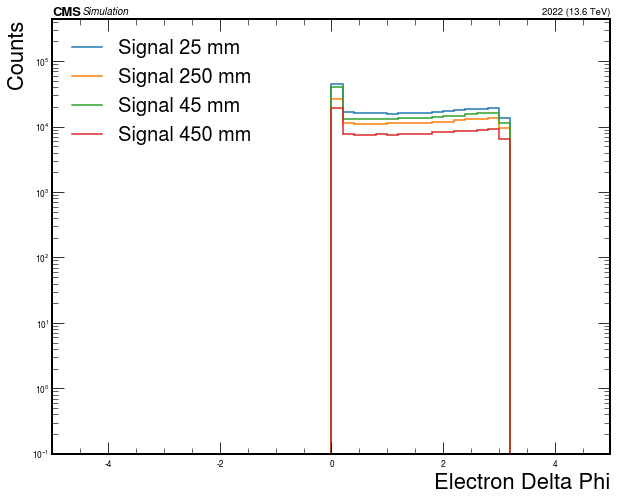

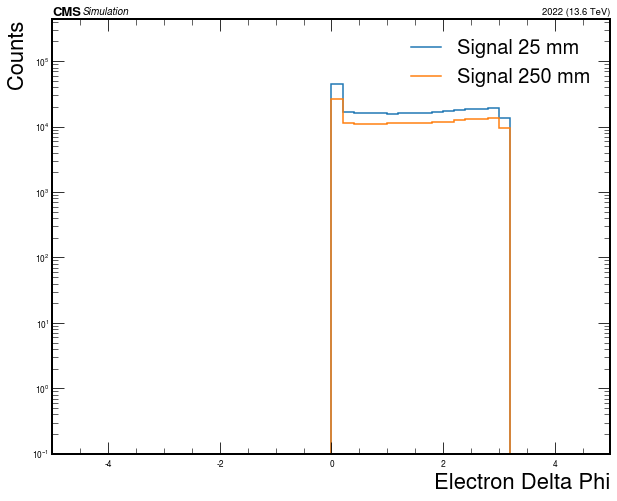

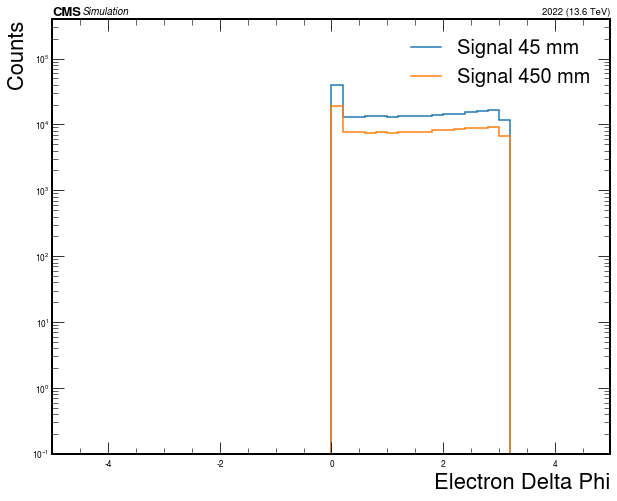

In [16]:
deltaphi_axis = np.linspace(-5, 5, 51)


DGR_hists = fourHistograms(fileName = "delta_Phi",
                                plotVariable = "delta_Phi",
                                plotAxis = deltaphi_axis, 
                                plotxlabel = "Electron Delta Phi",
                                Norm = False,
                                Di = False)

In [17]:
#signal250mm_rdf = signal250mm_rdf.Define("genParticle_A3D","ROOT::VecOps::RVec<float> Angle3D;for(size_t i = 0; i < genParticle_pt.size() - 1; ++i){double px0 = genParticle_pt[i] * cos(genParticle_phi[i]);double py0 = genParticle_pt[i] * sin(genParticle_phi[i]);double pz0 = genParticle_pt[i] * sinh(genParticle_eta[i]);double px1 = genParticle_pt[i + 1] * cos(genParticle_phi[i + 1]);double py1 = genParticle_pt[i + 1] * sin(genParticle_phi[i + 1]);double pz1 = genParticle_pt[i + 1] * sinh(genParticle_eta[i + 1]);double dotProduct = px0 * px1 + py0 * py1 + pz0 * pz1;double magnitude0 = sqrt(px0 * px0 + py0 * py0 + pz0 * pz0);double magnitude1 = sqrt(px1 * px1 + py1 * py1 + pz1 * pz1);double A3D = acos(dotProduct / (magnitude0 * magnitude1));Angle3D.push_back(A3D);}return Angle3D;")

In [18]:
signal25mm_rdf = signal25mm_rdf.Define("genParticle_A3D_elec","ROOT::VecOps::RVec<float> Angle3D_elec;for (size_t i = 0; i < genParticle_pt_elec.size() / 2; ++i) {size_t idx = i * 2;double px0_elec = genParticle_pt_elec[idx] * cos(genParticle_phi_elec[idx]);double py0_elec = genParticle_pt_elec[idx] * sin(genParticle_phi_elec[idx]);double pz0_elec = genParticle_pt_elec[idx] * sinh(genParticle_eta_elec[idx]);double px1_elec = genParticle_pt_elec[idx + 1] * cos(genParticle_phi_elec[idx + 1]);double py1_elec = genParticle_pt_elec[idx + 1] * sin(genParticle_phi_elec[idx + 1]);double pz1_elec = genParticle_pt_elec[idx + 1] * sinh(genParticle_eta_elec[idx + 1]);double dotProduct_elec = px0_elec * px1_elec + py0_elec * py1_elec + pz0_elec * pz1_elec;double magnitude0_elec = sqrt(px0_elec * px0_elec + py0_elec * py0_elec + pz0_elec * pz0_elec);double magnitude1_elec = sqrt(px1_elec * px1_elec + py1_elec * py1_elec + pz1_elec * pz1_elec);double A3D_elec = acos(dotProduct_elec / (magnitude0_elec * magnitude1_elec));Angle3D_elec.push_back(A3D_elec);}return Angle3D_elec")
signal250mm_rdf = signal250mm_rdf.Define("genParticle_A3D_elec","ROOT::VecOps::RVec<float> Angle3D_elec;for (size_t i = 0; i < genParticle_pt_elec.size() / 2; ++i) {size_t idx = i * 2;double px0_elec = genParticle_pt_elec[idx] * cos(genParticle_phi_elec[idx]);double py0_elec = genParticle_pt_elec[idx] * sin(genParticle_phi_elec[idx]);double pz0_elec = genParticle_pt_elec[idx] * sinh(genParticle_eta_elec[idx]);double px1_elec = genParticle_pt_elec[idx + 1] * cos(genParticle_phi_elec[idx + 1]);double py1_elec = genParticle_pt_elec[idx + 1] * sin(genParticle_phi_elec[idx + 1]);double pz1_elec = genParticle_pt_elec[idx + 1] * sinh(genParticle_eta_elec[idx + 1]);double dotProduct_elec = px0_elec * px1_elec + py0_elec * py1_elec + pz0_elec * pz1_elec;double magnitude0_elec = sqrt(px0_elec * px0_elec + py0_elec * py0_elec + pz0_elec * pz0_elec);double magnitude1_elec = sqrt(px1_elec * px1_elec + py1_elec * py1_elec + pz1_elec * pz1_elec);double A3D_elec = acos(dotProduct_elec / (magnitude0_elec * magnitude1_elec));Angle3D_elec.push_back(A3D_elec);}return Angle3D_elec")
signal45mm_rdf = signal45mm_rdf.Define("genParticle_A3D_elec","ROOT::VecOps::RVec<float> Angle3D_elec;for (size_t i = 0; i < genParticle_pt_elec.size() / 2; ++i) {size_t idx = i * 2;double px0_elec = genParticle_pt_elec[idx] * cos(genParticle_phi_elec[idx]);double py0_elec = genParticle_pt_elec[idx] * sin(genParticle_phi_elec[idx]);double pz0_elec = genParticle_pt_elec[idx] * sinh(genParticle_eta_elec[idx]);double px1_elec = genParticle_pt_elec[idx + 1] * cos(genParticle_phi_elec[idx + 1]);double py1_elec = genParticle_pt_elec[idx + 1] * sin(genParticle_phi_elec[idx + 1]);double pz1_elec = genParticle_pt_elec[idx + 1] * sinh(genParticle_eta_elec[idx + 1]);double dotProduct_elec = px0_elec * px1_elec + py0_elec * py1_elec + pz0_elec * pz1_elec;double magnitude0_elec = sqrt(px0_elec * px0_elec + py0_elec * py0_elec + pz0_elec * pz0_elec);double magnitude1_elec = sqrt(px1_elec * px1_elec + py1_elec * py1_elec + pz1_elec * pz1_elec);double A3D_elec = acos(dotProduct_elec / (magnitude0_elec * magnitude1_elec));Angle3D_elec.push_back(A3D_elec);}return Angle3D_elec")
signal450mm_rdf = signal450mm_rdf.Define("genParticle_A3D_elec","ROOT::VecOps::RVec<float> Angle3D_elec;for (size_t i = 0; i < genParticle_pt_elec.size() / 2; ++i) {size_t idx = i * 2;double px0_elec = genParticle_pt_elec[idx] * cos(genParticle_phi_elec[idx]);double py0_elec = genParticle_pt_elec[idx] * sin(genParticle_phi_elec[idx]);double pz0_elec = genParticle_pt_elec[idx] * sinh(genParticle_eta_elec[idx]);double px1_elec = genParticle_pt_elec[idx + 1] * cos(genParticle_phi_elec[idx + 1]);double py1_elec = genParticle_pt_elec[idx + 1] * sin(genParticle_phi_elec[idx + 1]);double pz1_elec = genParticle_pt_elec[idx + 1] * sinh(genParticle_eta_elec[idx + 1]);double dotProduct_elec = px0_elec * px1_elec + py0_elec * py1_elec + pz0_elec * pz1_elec;double magnitude0_elec = sqrt(px0_elec * px0_elec + py0_elec * py0_elec + pz0_elec * pz0_elec);double magnitude1_elec = sqrt(px1_elec * px1_elec + py1_elec * py1_elec + pz1_elec * pz1_elec);double A3D_elec = acos(dotProduct_elec / (magnitude0_elec * magnitude1_elec));Angle3D_elec.push_back(A3D_elec);}return Angle3D_elec")


In [19]:
signal25mm_rdf = signal25mm_rdf.Define("lowPtElectron_A3D","ROOT::VecOps::RVec<float> Angle3D;for (size_t i = 0; i < lowPtElectron_pt.size() / 2; ++i) {size_t idx = i * 2;if (deltaRGen[idx] < 0.2 && deltaRGen[idx + 1] < 0.2) {double px0 = lowPtElectron_pt[idx] * std::cos(lowPtElectron_phi[idx]);double py0 = lowPtElectron_pt[idx] * std::sin(lowPtElectron_phi[idx]);double pz0 = lowPtElectron_pt[idx] * std::sinh(lowPtElectron_eta[idx]);double px1 = lowPtElectron_pt[idx + 1] * std::cos(lowPtElectron_phi[idx + 1]);double py1 = lowPtElectron_pt[idx + 1] * std::sin(lowPtElectron_phi[idx + 1]);double pz1 = lowPtElectron_pt[idx + 1] * std::sinh(lowPtElectron_eta[idx + 1]);double dotProduct = px0 * px1 + py0 * py1 + pz0 * pz1;double magnitude0 = std::sqrt(px0 * px0 + py0 * py0 + pz0 * pz0);double magnitude1 = std::sqrt(px1 * px1 + py1 * py1 + pz1 * pz1);double A3D = std::acos(dotProduct / (magnitude0 * magnitude1));Angle3D.push_back(A3D);}}return Angle3D")
signal250mm_rdf = signal250mm_rdf.Define("lowPtElectron_A3D","ROOT::VecOps::RVec<float> Angle3D;for (size_t i = 0; i < lowPtElectron_pt.size() / 2; ++i) {size_t idx = i * 2;if (deltaRGen[idx] < 0.2 && deltaRGen[idx + 1] < 0.2) {double px0 = lowPtElectron_pt[idx] * std::cos(lowPtElectron_phi[idx]);double py0 = lowPtElectron_pt[idx] * std::sin(lowPtElectron_phi[idx]);double pz0 = lowPtElectron_pt[idx] * std::sinh(lowPtElectron_eta[idx]);double px1 = lowPtElectron_pt[idx + 1] * std::cos(lowPtElectron_phi[idx + 1]);double py1 = lowPtElectron_pt[idx + 1] * std::sin(lowPtElectron_phi[idx + 1]);double pz1 = lowPtElectron_pt[idx + 1] * std::sinh(lowPtElectron_eta[idx + 1]);double dotProduct = px0 * px1 + py0 * py1 + pz0 * pz1;double magnitude0 = std::sqrt(px0 * px0 + py0 * py0 + pz0 * pz0);double magnitude1 = std::sqrt(px1 * px1 + py1 * py1 + pz1 * pz1);double A3D = std::acos(dotProduct / (magnitude0 * magnitude1));Angle3D.push_back(A3D);}}return Angle3D")
signal45mm_rdf = signal45mm_rdf.Define("lowPtElectron_A3D","ROOT::VecOps::RVec<float> Angle3D;for (size_t i = 0; i < lowPtElectron_pt.size() / 2; ++i) {size_t idx = i * 2;if (deltaRGen[idx] < 0.2 && deltaRGen[idx + 1] < 0.2) {double px0 = lowPtElectron_pt[idx] * std::cos(lowPtElectron_phi[idx]);double py0 = lowPtElectron_pt[idx] * std::sin(lowPtElectron_phi[idx]);double pz0 = lowPtElectron_pt[idx] * std::sinh(lowPtElectron_eta[idx]);double px1 = lowPtElectron_pt[idx + 1] * std::cos(lowPtElectron_phi[idx + 1]);double py1 = lowPtElectron_pt[idx + 1] * std::sin(lowPtElectron_phi[idx + 1]);double pz1 = lowPtElectron_pt[idx + 1] * std::sinh(lowPtElectron_eta[idx + 1]);double dotProduct = px0 * px1 + py0 * py1 + pz0 * pz1;double magnitude0 = std::sqrt(px0 * px0 + py0 * py0 + pz0 * pz0);double magnitude1 = std::sqrt(px1 * px1 + py1 * py1 + pz1 * pz1);double A3D = std::acos(dotProduct / (magnitude0 * magnitude1));Angle3D.push_back(A3D);}}return Angle3D")
signal450mm_rdf = signal450mm_rdf.Define("lowPtElectron_A3D","ROOT::VecOps::RVec<float> Angle3D;for (size_t i = 0; i < lowPtElectron_pt.size() / 2; ++i) {size_t idx = i * 2;if (deltaRGen[idx] < 0.2 && deltaRGen[idx + 1] < 0.2) {double px0 = lowPtElectron_pt[idx] * std::cos(lowPtElectron_phi[idx]);double py0 = lowPtElectron_pt[idx] * std::sin(lowPtElectron_phi[idx]);double pz0 = lowPtElectron_pt[idx] * std::sinh(lowPtElectron_eta[idx]);double px1 = lowPtElectron_pt[idx + 1] * std::cos(lowPtElectron_phi[idx + 1]);double py1 = lowPtElectron_pt[idx + 1] * std::sin(lowPtElectron_phi[idx + 1]);double pz1 = lowPtElectron_pt[idx + 1] * std::sinh(lowPtElectron_eta[idx + 1]);double dotProduct = px0 * px1 + py0 * py1 + pz0 * pz1;double magnitude0 = std::sqrt(px0 * px0 + py0 * py0 + pz0 * pz0);double magnitude1 = std::sqrt(px1 * px1 + py1 * py1 + pz1 * pz1);double A3D = std::acos(dotProduct / (magnitude0 * magnitude1));Angle3D.push_back(A3D);}}return Angle3D")


In [20]:
display = signal250mm_rdf.Display([ "nLowPtElectron", "delta_Phi","genParticle_pdgId","deltaRGen","genParticle_lxy","lowPtElectron_pt"])
display.Print()

+-----+----------------+--------------+-------------------+--------------+-----------------+-----+
| Row | nLowPtElectron | delta_Phi    | genParticle_pdgId | deltaRGen    | genParticle_lxy | ... | 
+-----+----------------+--------------+-------------------+--------------+-----------------+-----+
| 0   | 3              | 0.000702024f | -11               | 0.000702582f | 3.12836f        | ... | 
|     |                | 0.868900f    | 11                | 3.04179f     | 3.12836f        | ... | 
|     |                | 0.259570f    | 13                | 3.06542f     | 18.0753f        | ... | 
|     |                | 0.958345f    | -13               | 0.929770f    | 18.0753f        | ... | 
|     |                | 2.94512f     |                   |              |                 | ... | 
|     |                | 2.46987f     |                   |              |                 | ... | 
|     |                | 3.07920f     |                   |              |                 | ... | 
| 

Info in <Print>: Only showing 6 columns out of 7



In [21]:
#display = signal250mm_rdf.Display(["genParticle_pt_elec","deltaRGen","genParticle_pt","lowPtElectron_A3D","genParticle_pdgId"])
#display.Print()

In [22]:
'''signal25mm_rdf_elec = signal25mm_rdf.Filter('genParticle_pdgId == -11 || genParticle_pdgId == 11') 
signal250mm_rdf_elec = signal250mm_rdf.Filter('genParticle_pdgId == -11 || genParticle_pdgId == 11') 
signal45mm_rdf_elec = signal45mm_rdf.Filter('genParticle_pdgId == -11 || genParticle_pdgId == 11') 
signal450mm_rdf_elec = signal450mm_rdf.Filter('genParticle_pdgId == -11 || genParticle_pdgId == 11')
'''

"signal25mm_rdf_elec = signal25mm_rdf.Filter('genParticle_pdgId == -11 || genParticle_pdgId == 11') \nsignal250mm_rdf_elec = signal250mm_rdf.Filter('genParticle_pdgId == -11 || genParticle_pdgId == 11') \nsignal45mm_rdf_elec = signal45mm_rdf.Filter('genParticle_pdgId == -11 || genParticle_pdgId == 11') \nsignal450mm_rdf_elec = signal450mm_rdf.Filter('genParticle_pdgId == -11 || genParticle_pdgId == 11')\n"

In [23]:
#display = signal25mm_rdf_elec.Display([ "nLowPtElectron", "genParticle_pdgId","genParticle_3d_angle"])
#display.Print()

In [24]:
signal25mm_rdf_Di = signal25mm_rdf.Filter('nLowPtElectron == 2') 
signal250mm_rdf_Di = signal250mm_rdf.Filter('nLowPtElectron == 2') 
signal45mm_rdf_Di = signal45mm_rdf.Filter('nLowPtElectron == 2') 
signal450mm_rdf_Di = signal450mm_rdf.Filter('nLowPtElectron == 2')

In [25]:
column_names = signal25mm_rdf.GetColumnNames()
for colname in column_names:
    print(colname)

Delta_Dxy
Delta_R
Delta_eta
Dielectron_mass
SC_et
SC_eta
SC_phi
SC_seedTime
dBSig
deltaRCon
deltaRGen
delta_Phi
event
genParticle_3d_angle
genParticle_3d_angle_elec
genParticle_A3D_elec
genParticle_Lxy_SV
genParticle_eta
genParticle_eta_elec
genParticle_index
genParticle_index_elec
genParticle_lxy
genParticle_lxy_elec
genParticle_m
genParticle_m_elec
genParticle_motherIndex
genParticle_motherIndex_elec
genParticle_motherPdgId
genParticle_motherPdgId_elec
genParticle_pdgId
genParticle_phi
genParticle_phi_elec
genParticle_pt
genParticle_pt_elec
genParticle_px0
genParticle_px0_elec
genParticle_px1
genParticle_px1_elec
genParticle_py0
genParticle_py0_elec
genParticle_py1
genParticle_py1_elec
genParticle_pz0
genParticle_pz0_elec
genParticle_pz1
genParticle_pz1_elec
genParticle_status
genParticle_status_elec
genParticle_vx
genParticle_vx_elec
genParticle_vy
genParticle_vy_elec
genParticle_vz
genParticle_vz_elec
lowPtElectron_3d_angle
lowPtElectron_A3D
lowPtElectron_Lxy_SV
lowPtElectron_charg

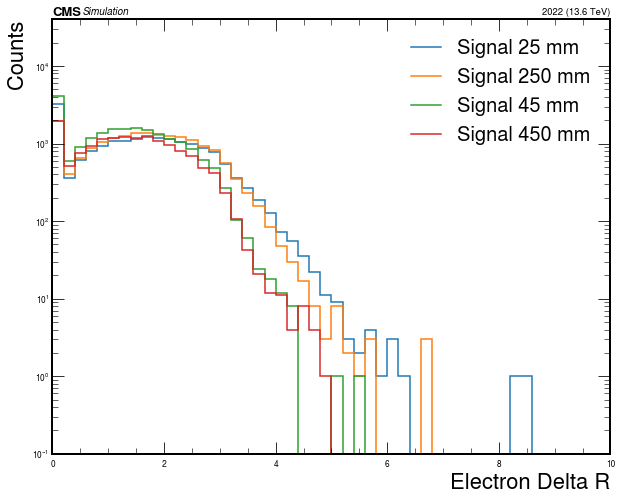

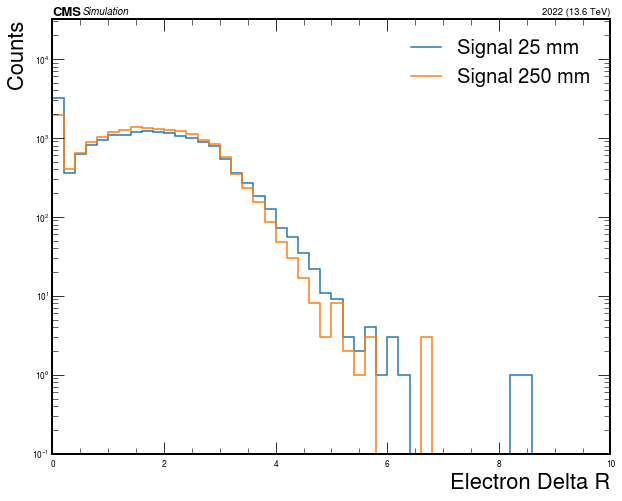

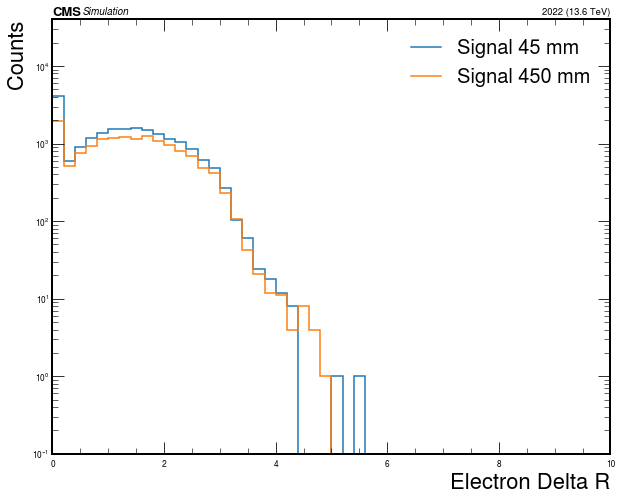

In [26]:
deltaRGen_axis = np.linspace(0, 10, 51)


DGR_hists = fourHistograms(fileName = "deltaRGen",
                                plotVariable = "deltaRGen",
                                plotAxis = deltaRGen_axis, 
                                plotxlabel = "Electron Delta R",
                                Norm = False)

Name: genParticle_pt_sel Title:  NbinsX: 50
Name: genParticle_pt_sel Title:  NbinsX: 50
Name: genParticle_pt_sel Title:  NbinsX: 50
Name: genParticle_pt_sel Title:  NbinsX: 50
Name: genParticle_pt_sel Title:  NbinsX: 50
Name: genParticle_pt_sel Title:  NbinsX: 50
Name: genParticle_pt_sel Title:  NbinsX: 50
Name: genParticle_pt_sel Title:  NbinsX: 50


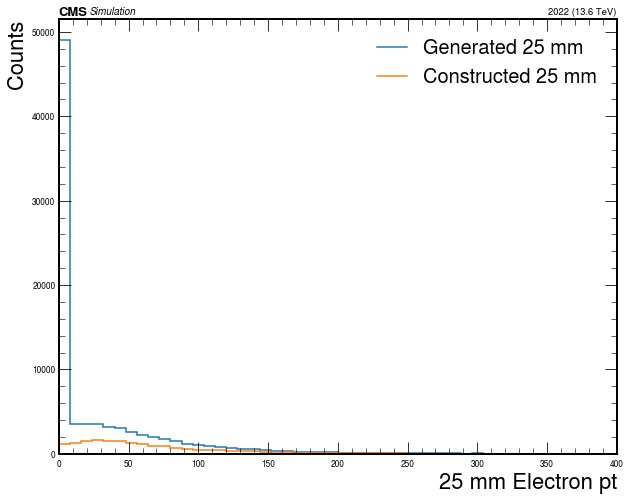

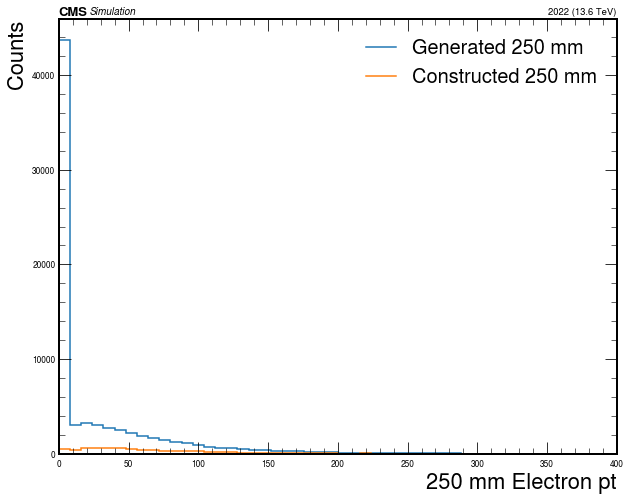

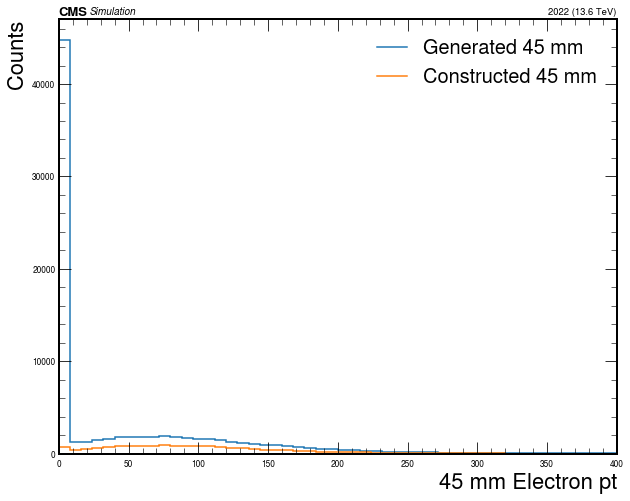

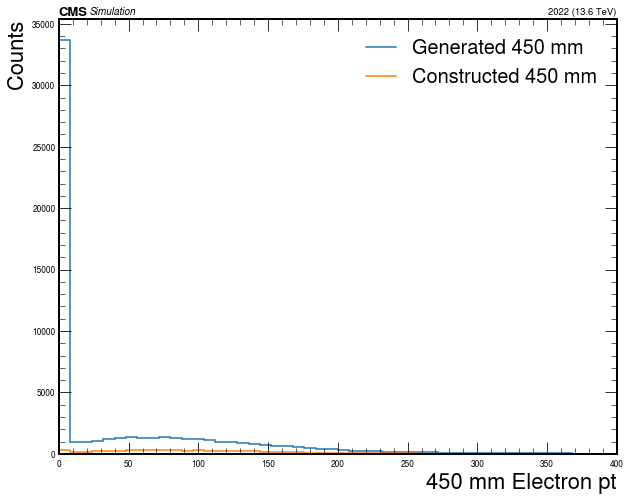

In [27]:
pt_axis = np.linspace(0, 400, 51)
pt_hists = efficiency(fileName = "Pt",
                                plotVariable = "pt",
                                plotAxis = [pt_axis], 
                                plotxlabel = "Electron pt")

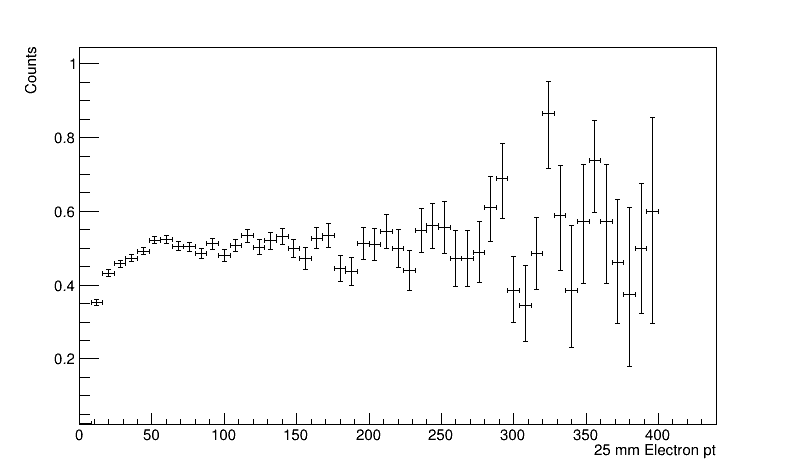

In [28]:
c1 = r.TCanvas('c1', '', 800, 500)
c1.cd()
pt_hists[0].Draw("AP")
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


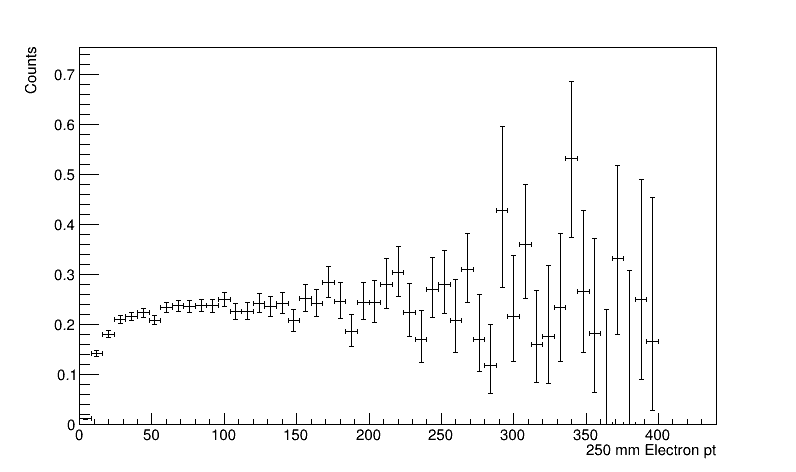

In [29]:
c1 = r.TCanvas('c1', '', 800, 500)
c1.cd()
pt_hists[1].Draw("AP")
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


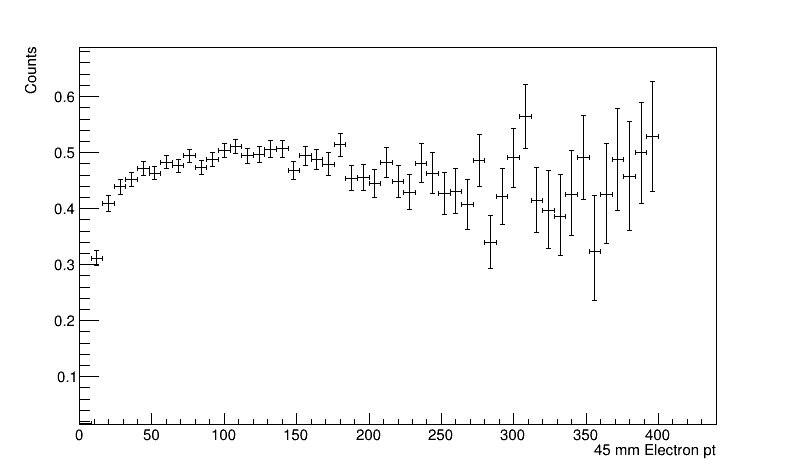

In [30]:
c1 = r.TCanvas('c1', '', 800, 500)
c1.cd()
pt_hists[2].Draw("AP")
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


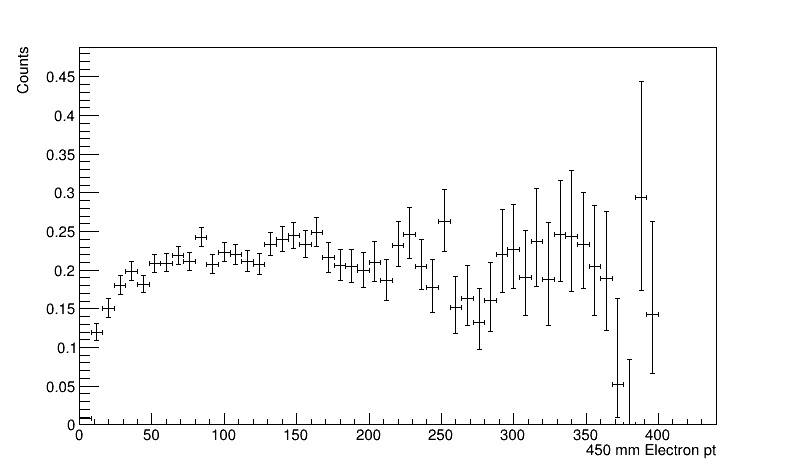

In [31]:
c1 = r.TCanvas('c1', '', 800, 500)
c1.cd()
pt_hists[3].Draw("AP")
c1.Draw()

Name: genParticle_phi_sel Title:  NbinsX: 50
Name: genParticle_phi_sel Title:  NbinsX: 50
Name: genParticle_phi_sel Title:  NbinsX: 50
Name: genParticle_phi_sel Title:  NbinsX: 50
Name: genParticle_phi_sel Title:  NbinsX: 50
Name: genParticle_phi_sel Title:  NbinsX: 50
Name: genParticle_phi_sel Title:  NbinsX: 50
Name: genParticle_phi_sel Title:  NbinsX: 50


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


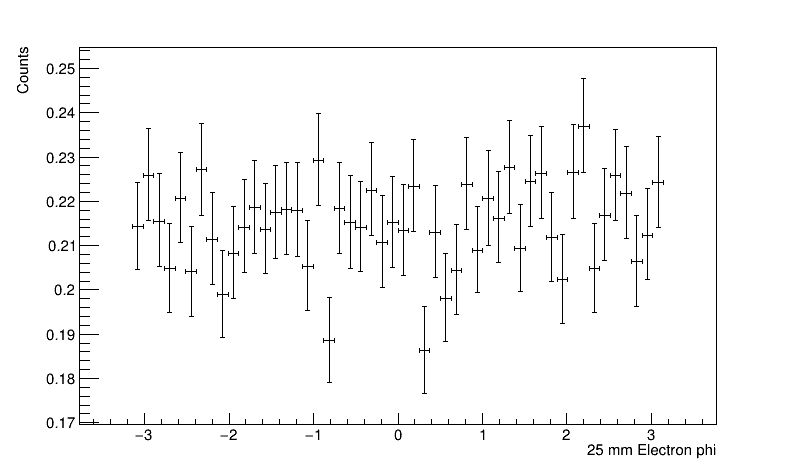

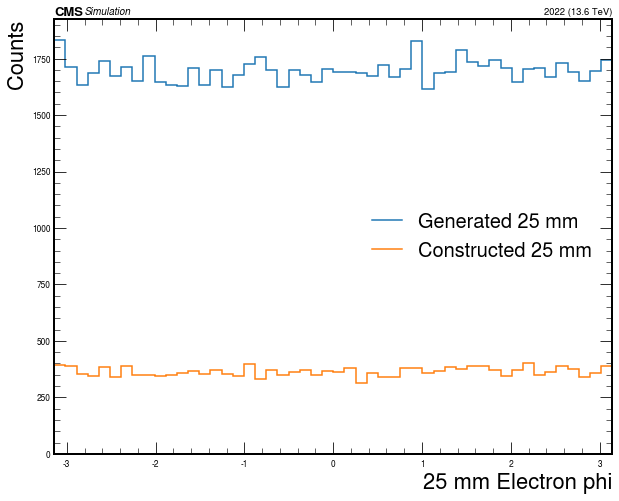

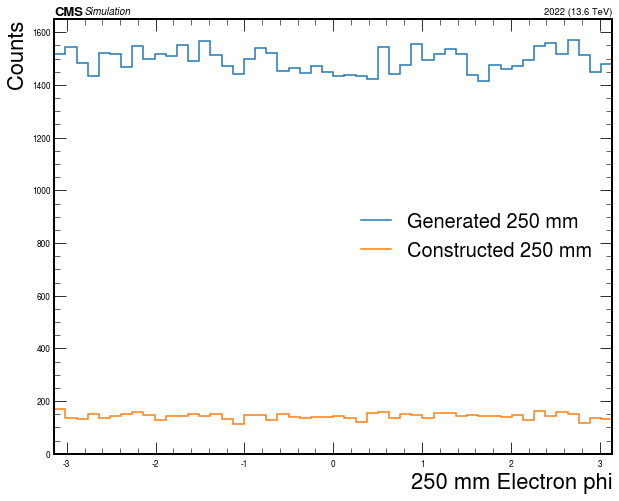

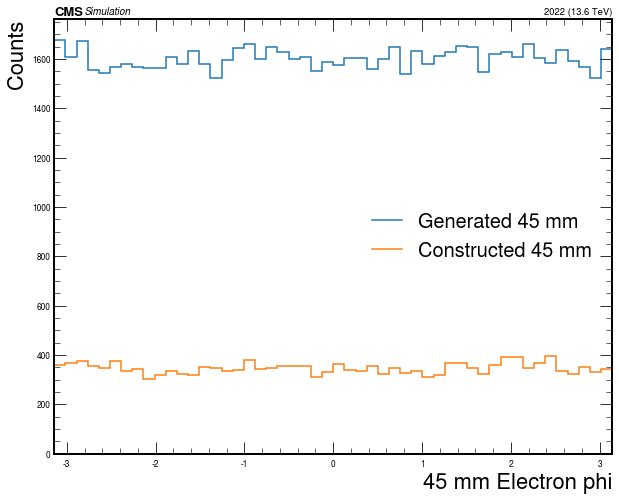

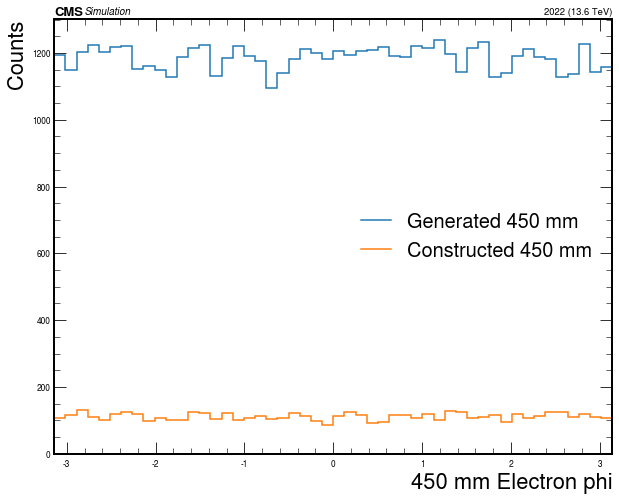

In [32]:
phi_axis = np.linspace(-np.pi, np.pi, 51)
phi_hists = efficiency(fileName = "Phi",
                                plotVariable = "phi",
                                plotAxis = [phi_axis], 
                                plotxlabel = "Electron phi")

c1 = r.TCanvas('c1', '', 800, 500)
c1.cd()
phi_hists[0].Draw("AP")
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


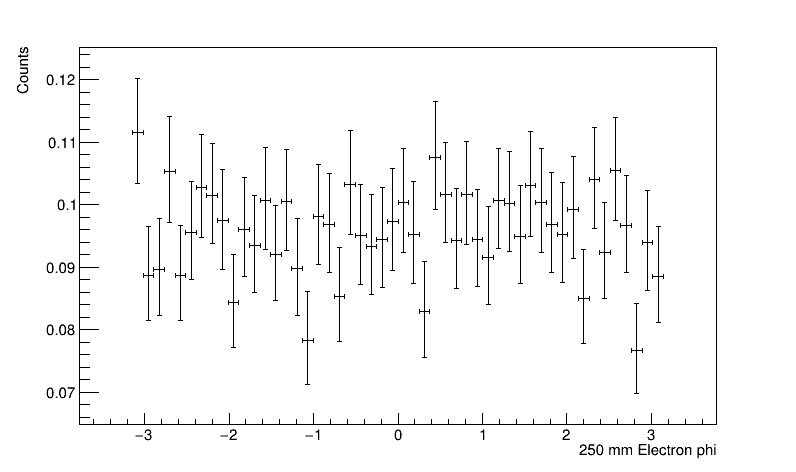

In [33]:
c1 = r.TCanvas('c1', '', 800, 500)
c1.cd()
phi_hists[1].Draw("AP")
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


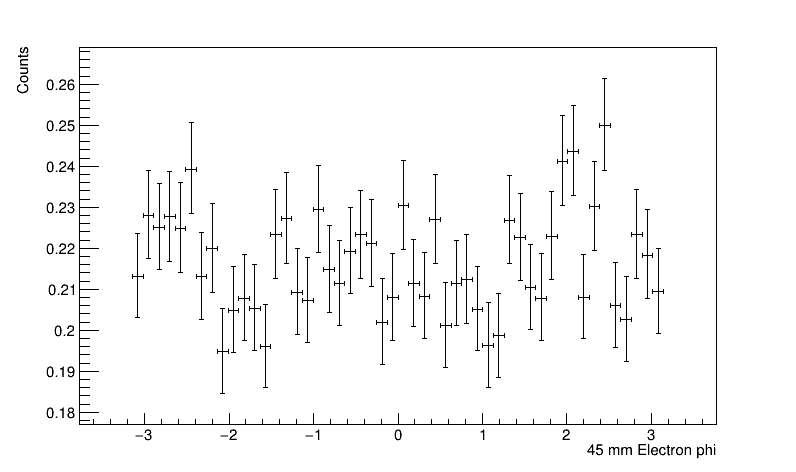

In [34]:
c1 = r.TCanvas('c1', '', 800, 500)
c1.cd()
phi_hists[2].Draw("AP")
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


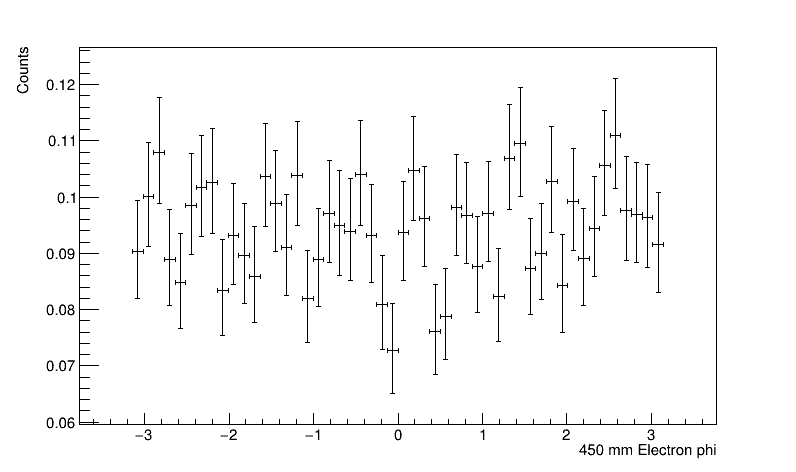

In [35]:
c1 = r.TCanvas('c1', '', 800, 500)
c1.cd()
phi_hists[3].Draw("AP")
c1.Draw()

Name: genParticle_lxy_sel Title:  NbinsX: 50
Name: genParticle_lxy_sel Title:  NbinsX: 50


/tmp/ipykernel_461/2306776495.py:85: RuntimeWarning: divide by zero encountered in divide
  hs.append(getValues(histos[0])/getValues(histos[1]))
/tmp/ipykernel_461/2306776495.py:85: RuntimeWarning: invalid value encountered in divide
  hs.append(getValues(histos[0])/getValues(histos[1]))


Name: genParticle_lxy_sel Title:  NbinsX: 50
Name: genParticle_lxy_sel Title:  NbinsX: 50
Name: genParticle_lxy_sel Title:  NbinsX: 50
Name: genParticle_lxy_sel Title:  NbinsX: 50


/tmp/ipykernel_461/2306776495.py:85: RuntimeWarning: divide by zero encountered in divide
  hs.append(getValues(histos[0])/getValues(histos[1]))
/tmp/ipykernel_461/2306776495.py:85: RuntimeWarning: invalid value encountered in divide
  hs.append(getValues(histos[0])/getValues(histos[1]))


Name: genParticle_lxy_sel Title:  NbinsX: 50
Name: genParticle_lxy_sel Title:  NbinsX: 50


'c1 = r.TCanvas(\'c1\', \'\', 800, 500)\nc1.cd()\nLxy_hists[0].Draw("AP")\nc1.Draw()'

Info in <TROOT::TEfficiency::CheckEntries>: Histograms are not consistent: passed bin content > total bin content
Error in <TROOT::TEfficiency::CheckConsistency>: passed TEfficiency objects do not have consistent bin contents
Info in <TROOT::TEfficiency::CheckEntries>: Histograms are not consistent: passed bin content > total bin content
Error in <TROOT::TEfficiency::CheckConsistency>: passed TEfficiency objects do not have consistent bin contents


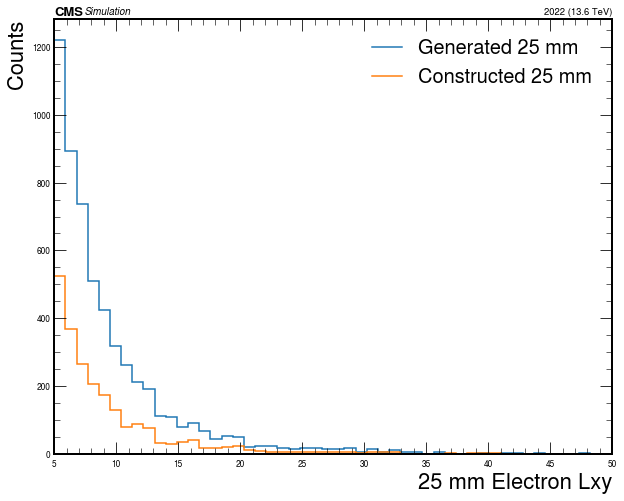

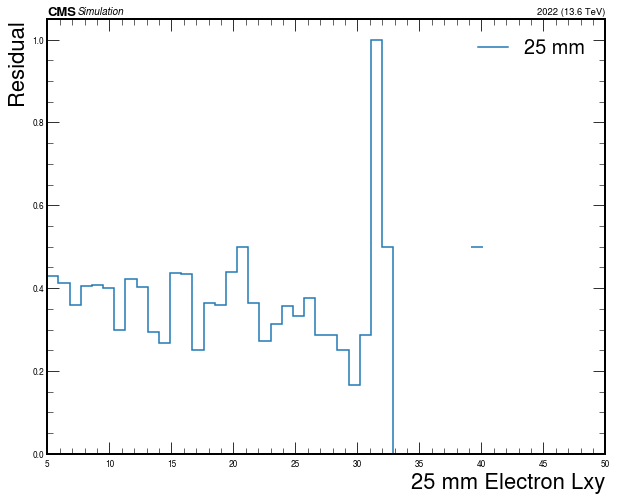

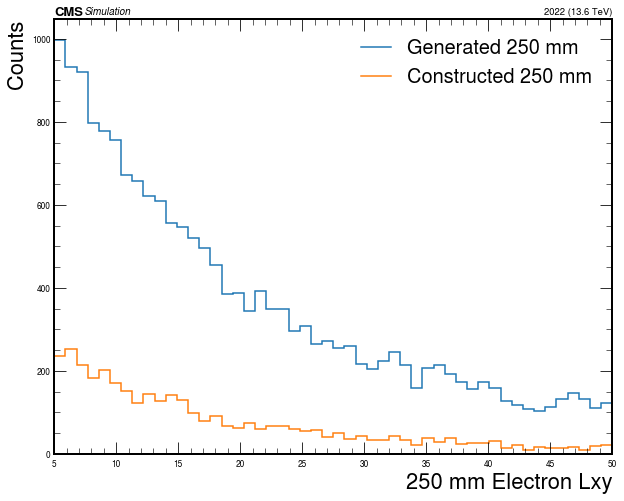

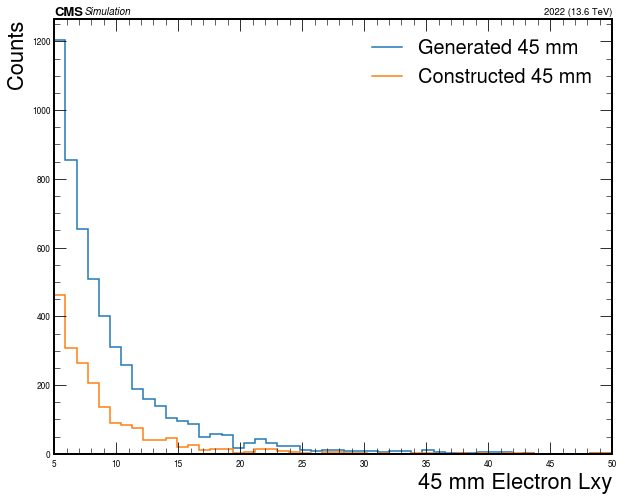

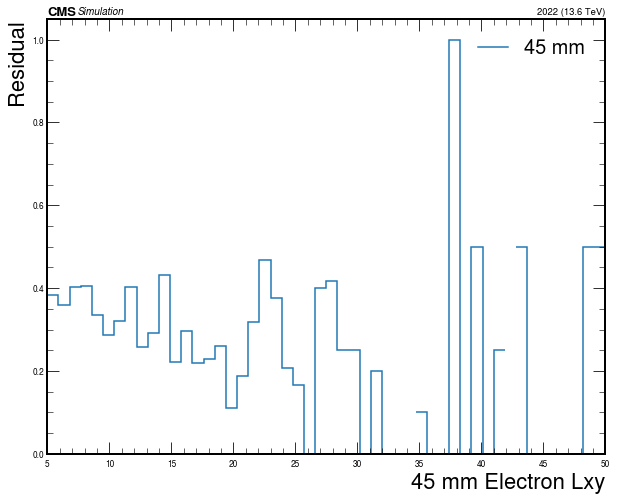

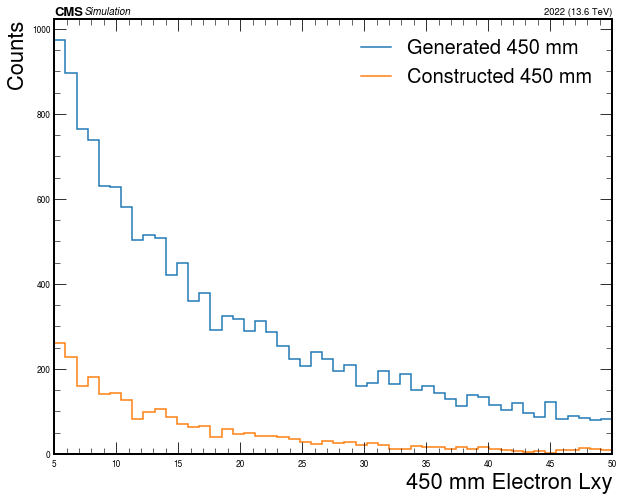

In [36]:
Lxy_axis = np.linspace(5, 50, 51)
Lxy_hists = efficiency(fileName = "Lxy",
                                plotVariable = "lxy",
                                plotAxis = [Lxy_axis], 
                                plotxlabel = "Electron Lxy",
                                restrictGenPt = True)
'''c1 = r.TCanvas('c1', '', 800, 500)
c1.cd()
Lxy_hists[0].Draw("AP")
c1.Draw()'''

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


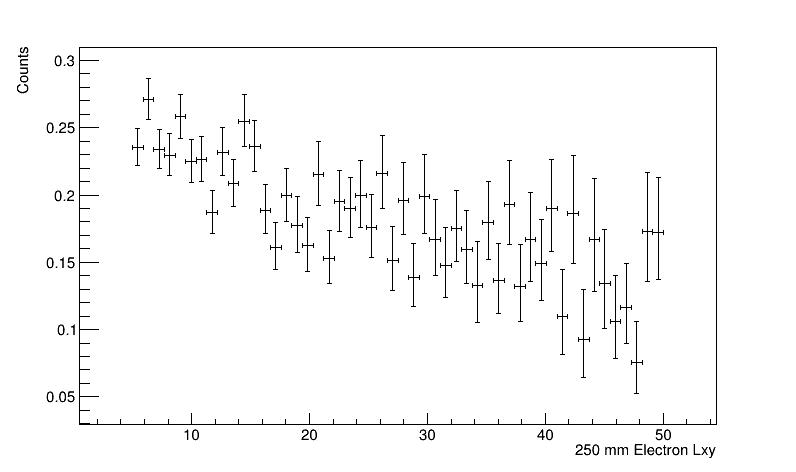

In [37]:
c1 = r.TCanvas('c1', '', 800, 500)
c1.cd()
Lxy_hists[1].Draw("AP")
c1.Draw()

In [38]:
#c1 = r.TCanvas('c1', '', 800, 500)
#c1.cd()
#Lxy_hists[2].Draw("AP")
#c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


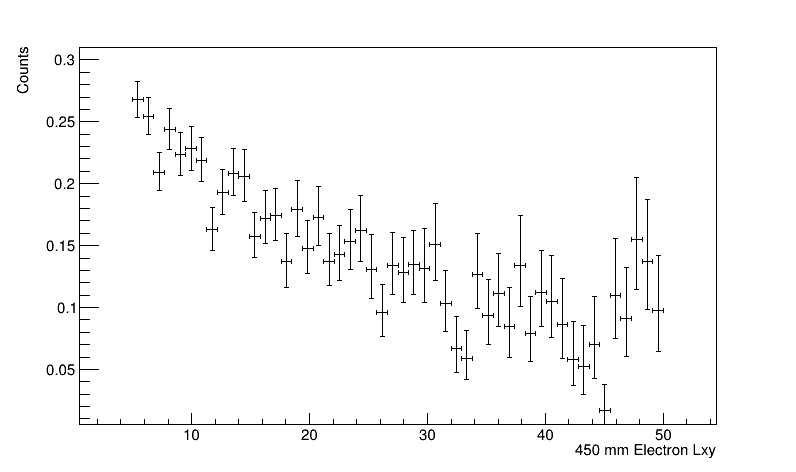

In [39]:
c1 = r.TCanvas('c1', '', 800, 500)
c1.cd()
Lxy_hists[3].Draw("AP")
c1.Draw()

Name: genParticle_Lxy_SV_sel Title:  NbinsX: 50
Name: genParticle_Lxy_SV_sel Title:  NbinsX: 50


/tmp/ipykernel_461/2306776495.py:85: RuntimeWarning: divide by zero encountered in divide
  hs.append(getValues(histos[0])/getValues(histos[1]))
/tmp/ipykernel_461/2306776495.py:85: RuntimeWarning: invalid value encountered in divide
  hs.append(getValues(histos[0])/getValues(histos[1]))


Name: genParticle_Lxy_SV_sel Title:  NbinsX: 50
Name: genParticle_Lxy_SV_sel Title:  NbinsX: 50
Name: genParticle_Lxy_SV_sel Title:  NbinsX: 50
Name: genParticle_Lxy_SV_sel Title:  NbinsX: 50
Name: genParticle_Lxy_SV_sel Title:  NbinsX: 50
Name: genParticle_Lxy_SV_sel Title:  NbinsX: 50


Info in <TROOT::TEfficiency::CheckEntries>: Histograms are not consistent: passed bin content > total bin content
Error in <TROOT::TEfficiency::CheckConsistency>: passed TEfficiency objects do not have consistent bin contents


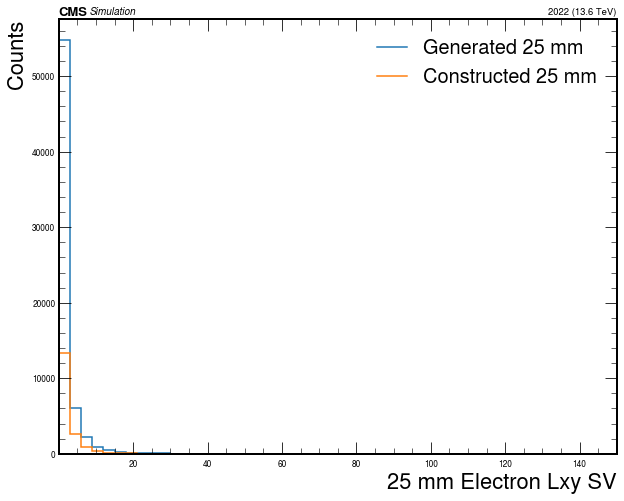

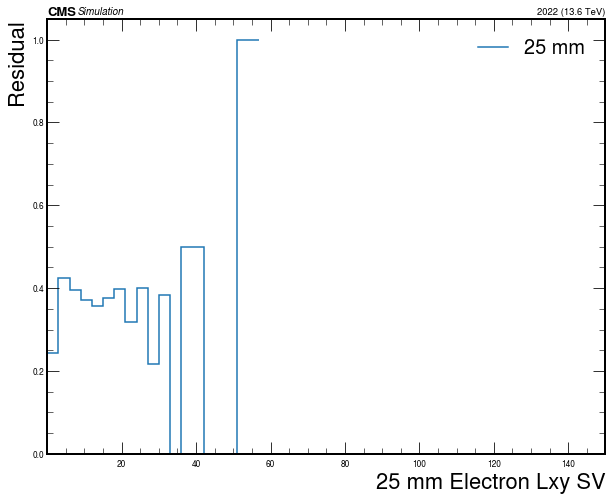

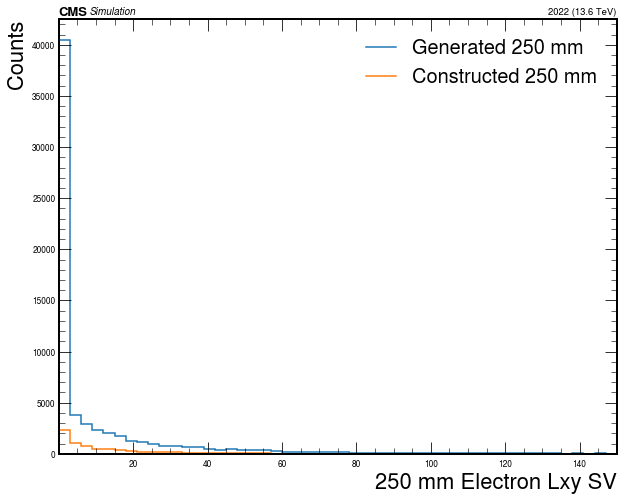

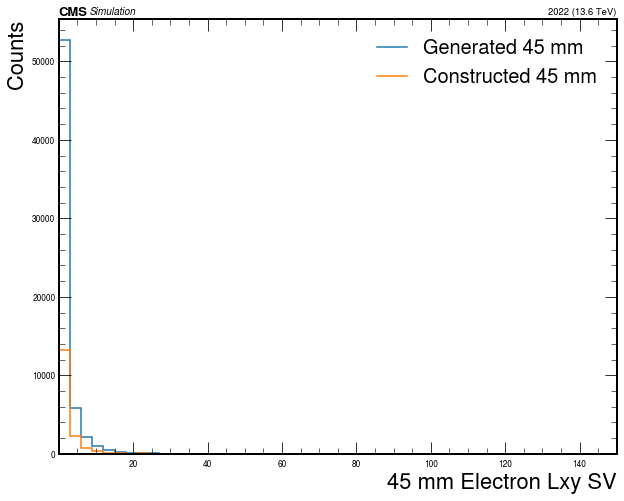

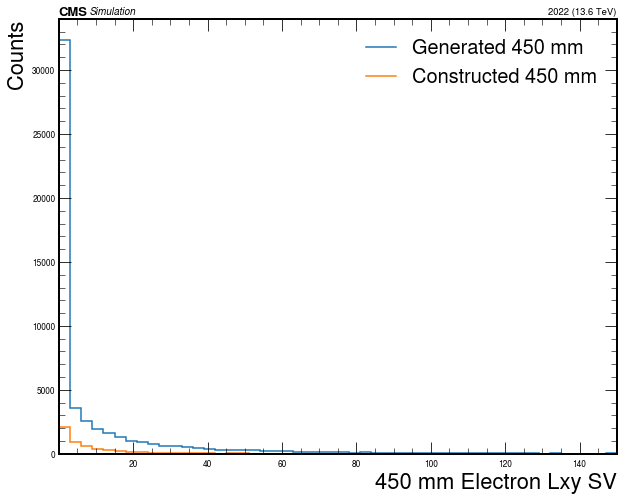

In [40]:
Lxy_SV_axis = np.linspace(.01, 150, 51)
Lxy_SV_hists = efficiency(fileName = "Lxy_SV",
                                plotVariable = "Lxy_SV",
                                plotAxis = [Lxy_SV_axis], 
                                plotxlabel = "Electron Lxy SV")

Name: genParticle_Lxy_SV_sel Title:  NbinsX: 50
Name: genParticle_Lxy_SV_sel Title:  NbinsX: 50
Name: genParticle_Lxy_SV_sel Title:  NbinsX: 50
Name: genParticle_Lxy_SV_sel Title:  NbinsX: 50
Name: genParticle_Lxy_SV_sel Title:  NbinsX: 50
Name: genParticle_Lxy_SV_sel Title:  NbinsX: 50
Name: genParticle_Lxy_SV_sel Title:  NbinsX: 50
Name: genParticle_Lxy_SV_sel Title:  NbinsX: 50


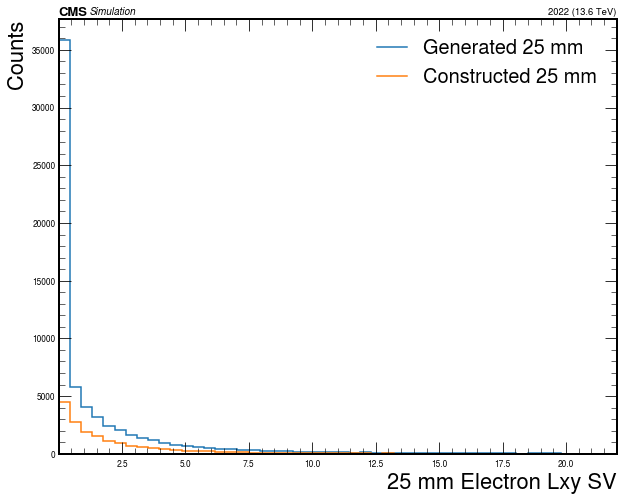

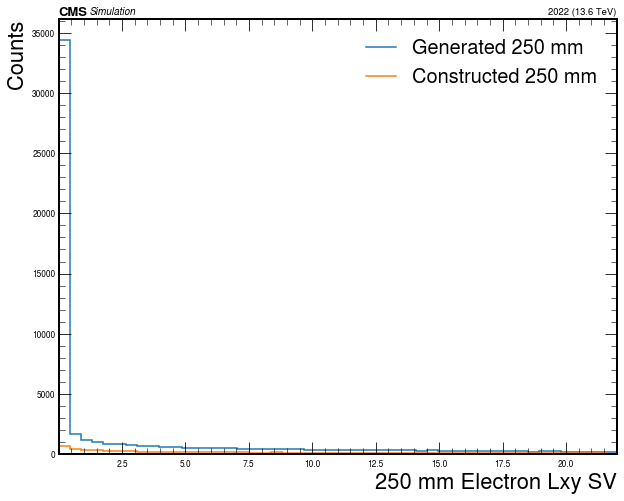

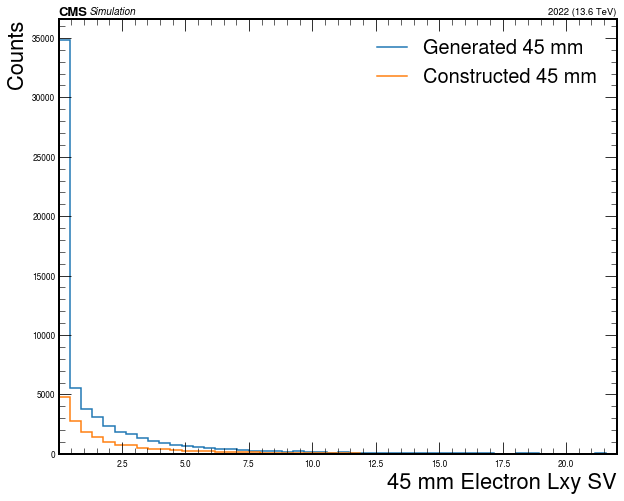

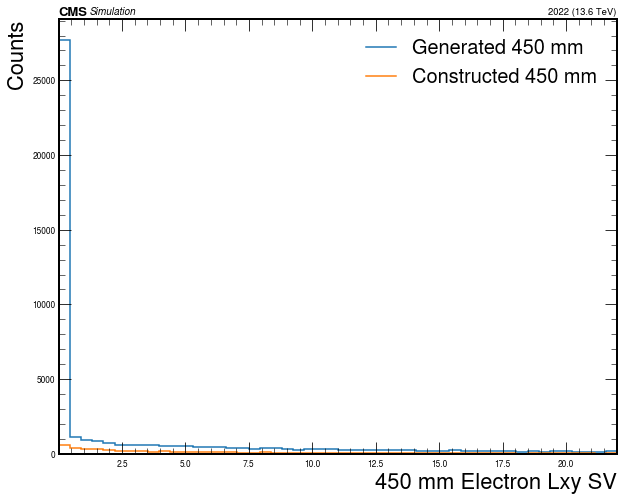

In [41]:
Lxy_SV_axis2 = np.linspace(.01, 22, 51)
Lxy_SV_hists2 = efficiency(fileName = "Lxy_SV2",
                                plotVariable = "Lxy_SV",
                                plotAxis = [Lxy_SV_axis2], 
                                plotxlabel = "Electron Lxy SV")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


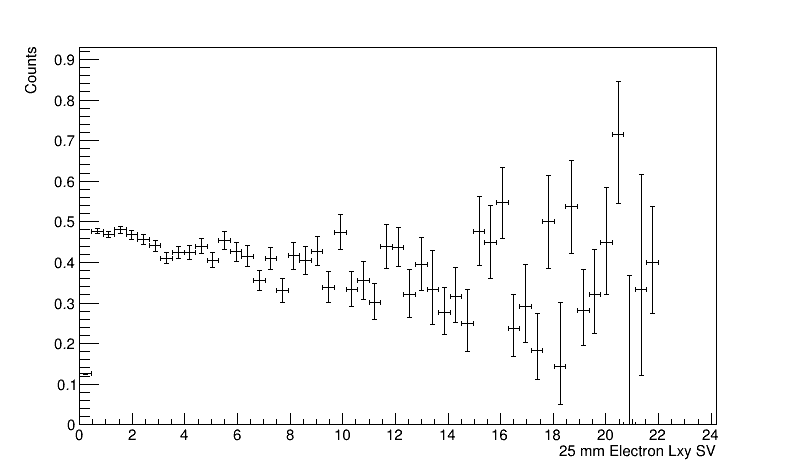

In [42]:
c1 = r.TCanvas('c1', '', 800, 500)
c1.cd()
Lxy_SV_hists2[0].Draw("AP")
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


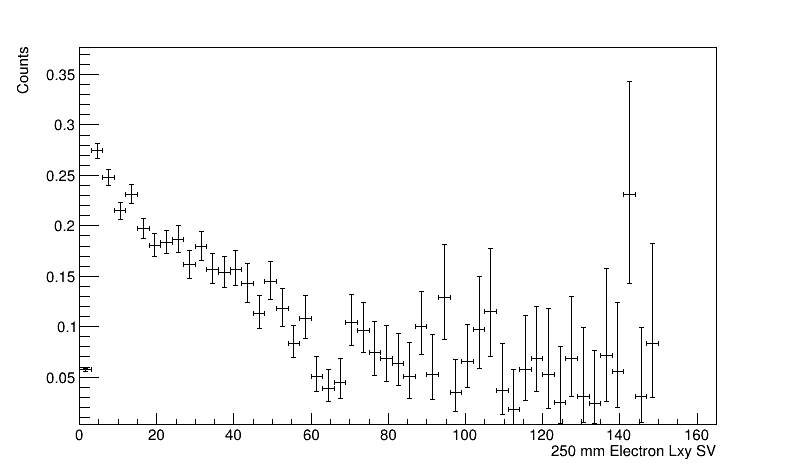

In [43]:
c1 = r.TCanvas('c1', '', 800, 500)
c1.cd()
Lxy_SV_hists[1].Draw("AP")
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


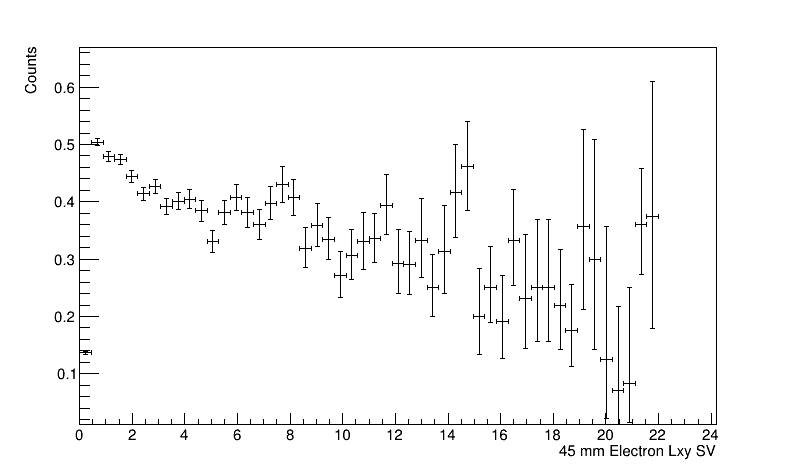

In [44]:
c1 = r.TCanvas('c1', '', 800, 500)
c1.cd()
Lxy_SV_hists2[2].Draw("AP")
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


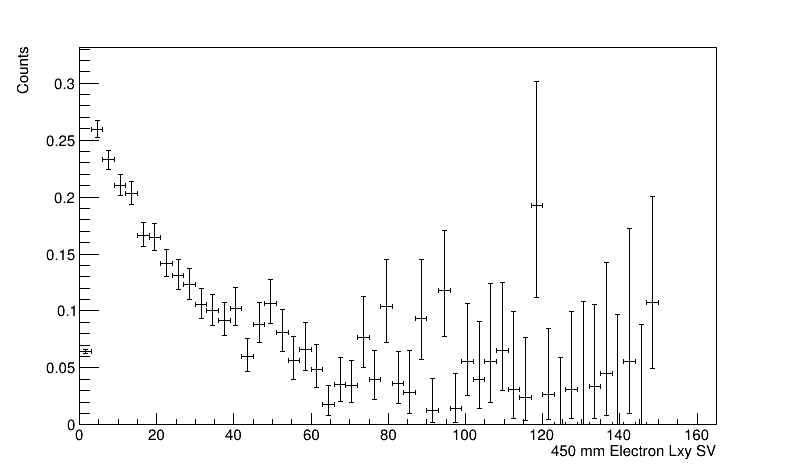

In [45]:
c1 = r.TCanvas('c1', '', 800, 500)
c1.cd()
Lxy_SV_hists[3].Draw("AP")
c1.Draw()

Name: genParticle_lxy_sel Title:  NbinsX: 50
Name: genParticle_lxy_sel Title:  NbinsX: 50
Name: genParticle_lxy_sel Title:  NbinsX: 50
Name: genParticle_lxy_sel Title:  NbinsX: 50
Name: genParticle_lxy_sel Title:  NbinsX: 50
Name: genParticle_lxy_sel Title:  NbinsX: 50
Name: genParticle_lxy_sel Title:  NbinsX: 50
Name: genParticle_lxy_sel Title:  NbinsX: 50


'Lxy_SV_axis2 = np.linspace(0, 25, 51)\nLxy_SV_hists2 = efficiency(fileName = "Lxy_SV2",\n                                plotVariable = "lxy",\n                                plotAxis = Lxy_SV_axis2, \n                                plotxlabel = "Electron Lxy SV",\n                              restrictGenPt = True) '

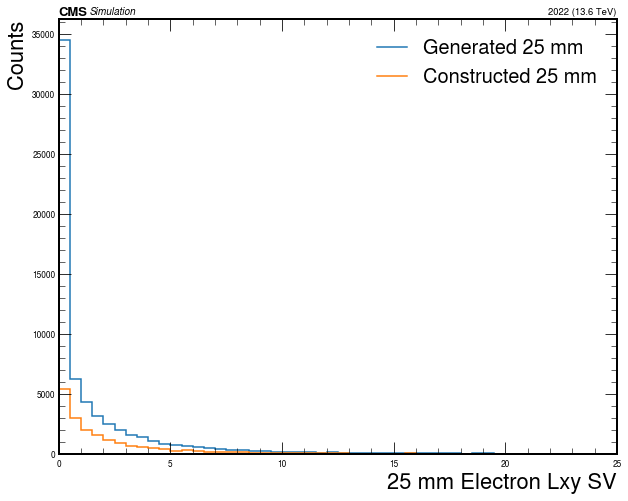

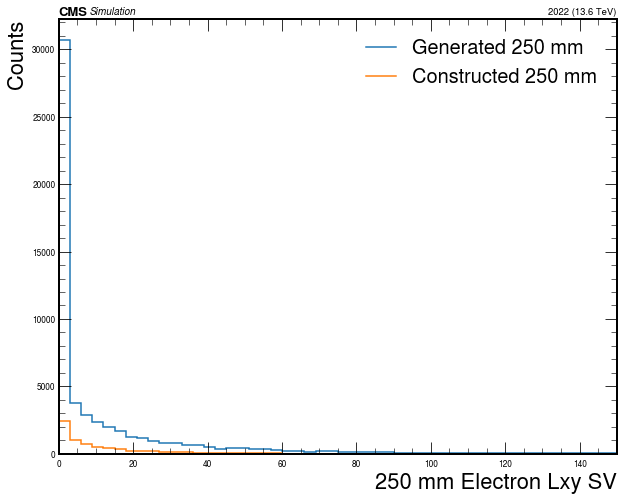

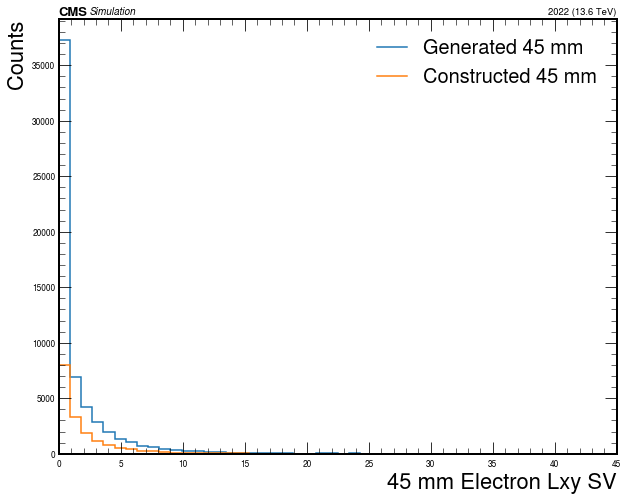

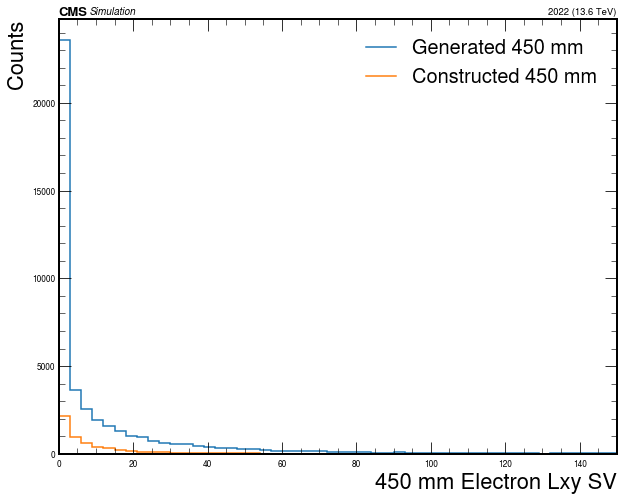

In [46]:
Lxy_SV_axis25 = np.linspace(0, 25, 51)
Lxy_SV_axis250 = np.linspace(0, 150, 51)
Lxy_SV_axis45 = np.linspace(0, 45, 51)
Lxy_SV_axis450 = np.linspace(0, 200, 51)
Lxy_SV_hists = efficiency(fileName = "Lxy_SV",
                                plotVariable = "lxy",
                                plotAxis = [Lxy_SV_axis25, Lxy_SV_axis250, Lxy_SV_axis45, Lxy_SV_axis250],
                                plotxlabel = "Electron Lxy SV",
                                restrictGenPt = True)

'''Lxy_SV_axis2 = np.linspace(0, 25, 51)
Lxy_SV_hists2 = efficiency(fileName = "Lxy_SV2",
                                plotVariable = "lxy",
                                plotAxis = Lxy_SV_axis2, 
                                plotxlabel = "Electron Lxy SV",
                              restrictGenPt = True) ''' 
#plotSelection


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


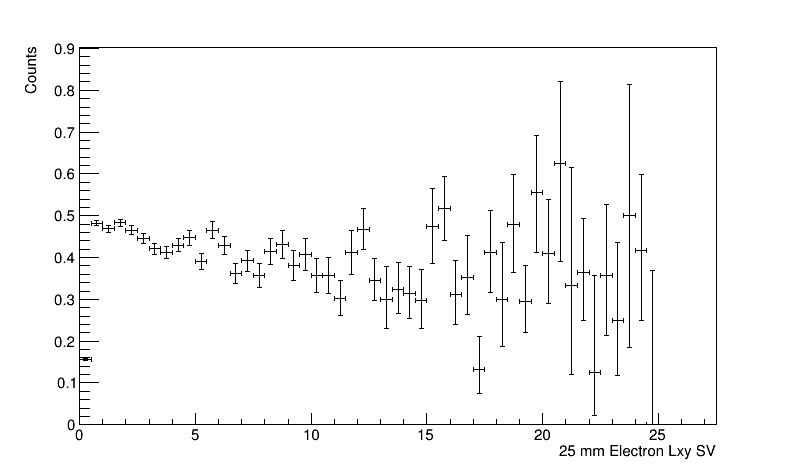

In [57]:
c1 = r.TCanvas('c1', '', 800, 500)
c1.cd()
Lxy_SV_hists[0].Draw("AP")
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


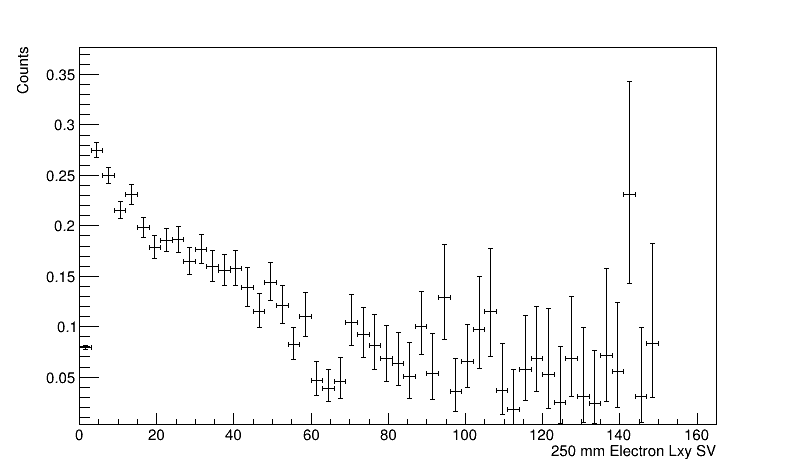

In [58]:
c1 = r.TCanvas('c1', '', 800, 500)
c1.cd()
Lxy_SV_hists[1].Draw("AP")
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


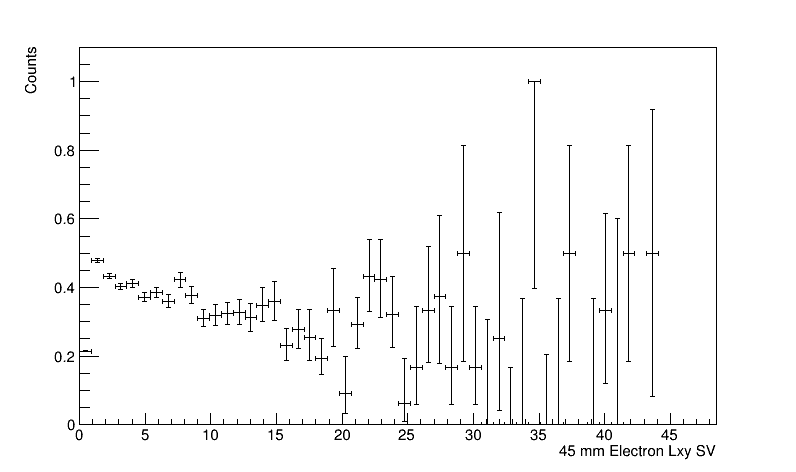

In [59]:
c1 = r.TCanvas('c1', '', 800, 500)
c1.cd()
Lxy_SV_hists[2].Draw("AP")
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


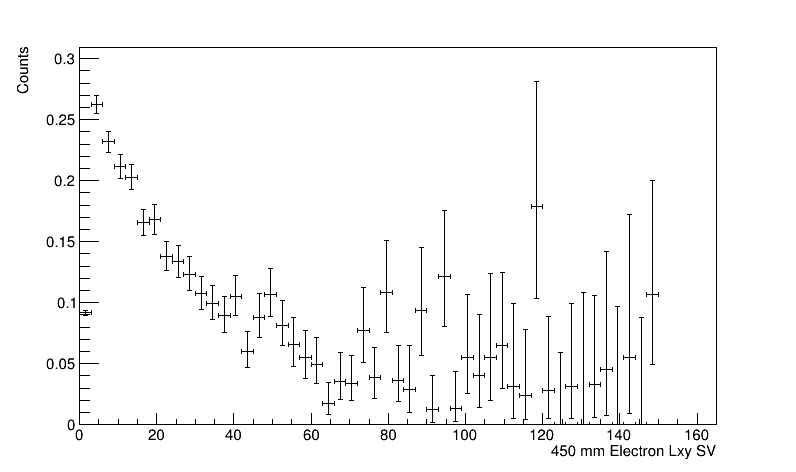

In [60]:
c1 = r.TCanvas('c1', '', 800, 500)
c1.cd()
Lxy_SV_hists[3].Draw("AP")
c1.Draw()

Name: genParticle_eta_sel Title:  NbinsX: 50
Name: genParticle_eta_sel Title:  NbinsX: 50
Name: genParticle_eta_sel Title:  NbinsX: 50
Name: genParticle_eta_sel Title:  NbinsX: 50
Name: genParticle_eta_sel Title:  NbinsX: 50
Name: genParticle_eta_sel Title:  NbinsX: 50
Name: genParticle_eta_sel Title:  NbinsX: 50
Name: genParticle_eta_sel Title:  NbinsX: 50


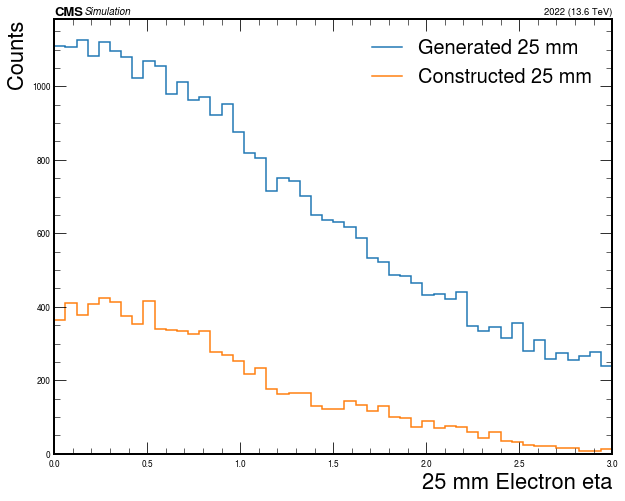

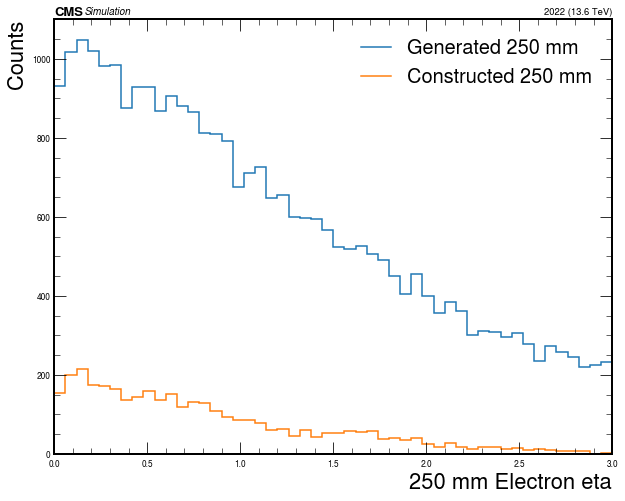

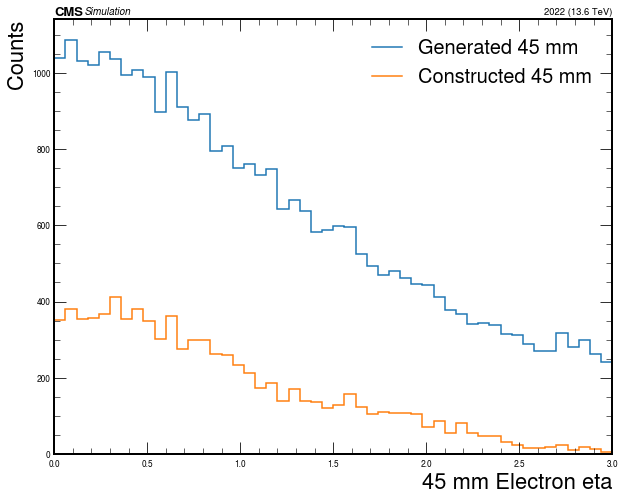

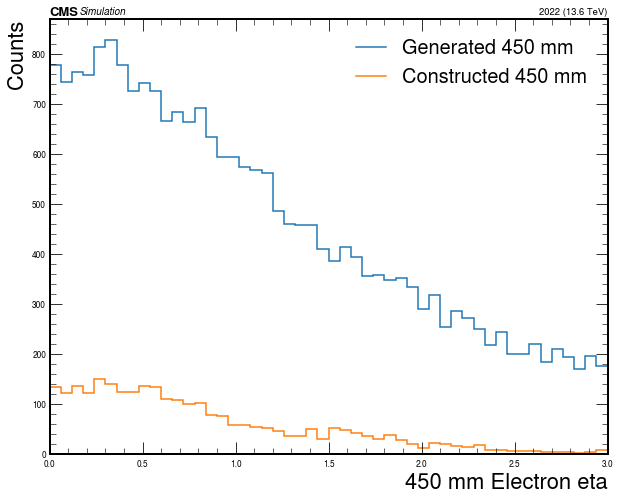

In [51]:
eta_axis = np.linspace(0, 3, 51)
eta_hists = efficiency(fileName = "eta",
                                plotVariable = "eta",
                                plotAxis = [eta_axis], 
                                plotxlabel = "Electron eta")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


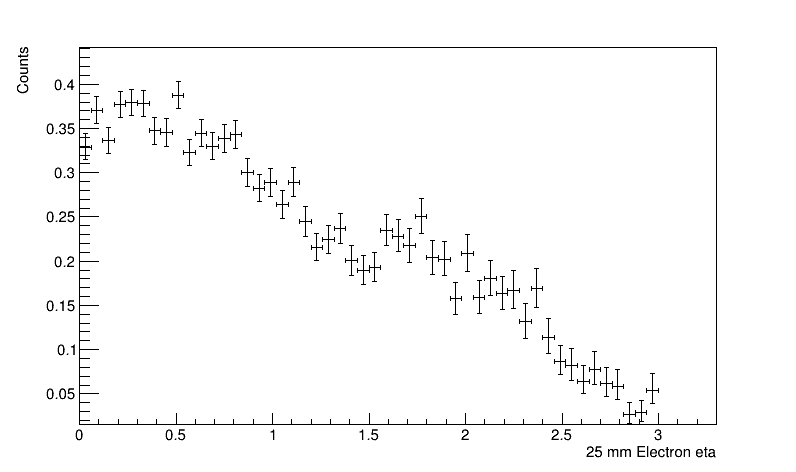

In [52]:
c1 = r.TCanvas('c1', '', 800, 500)
c1.cd()
eta_hists[0].Draw("AP")
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


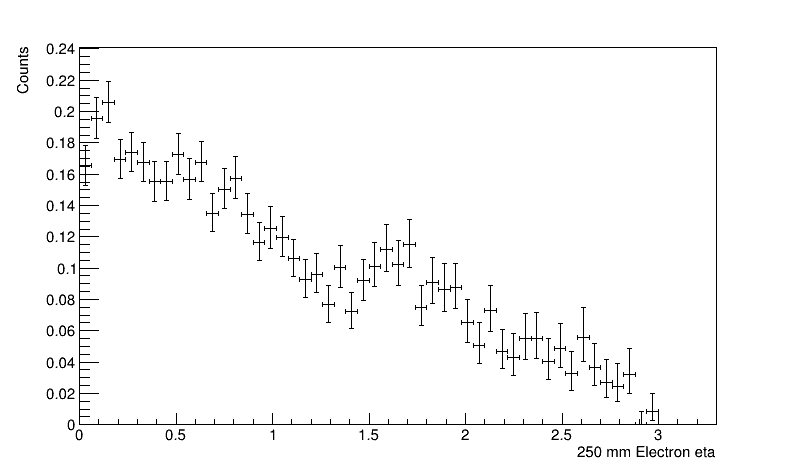

In [53]:
c1 = r.TCanvas('c1', '', 800, 500)
c1.cd()
eta_hists[1].Draw("AP")
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


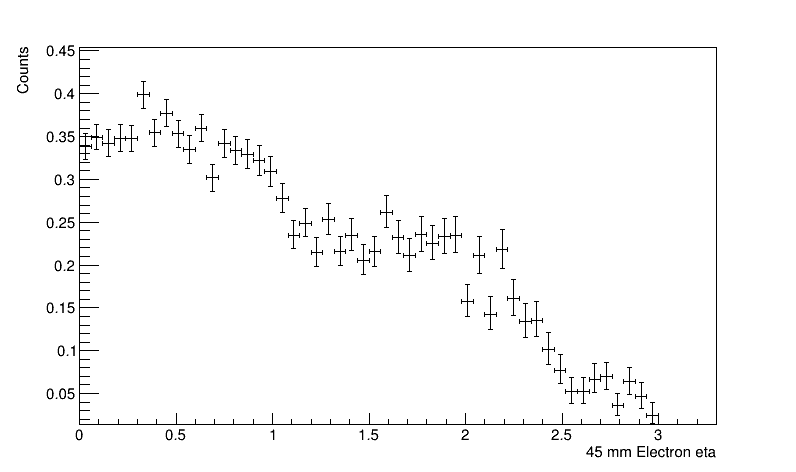

In [54]:
c1 = r.TCanvas('c1', '', 800, 500)
c1.cd()
eta_hists[2].Draw("AP")
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


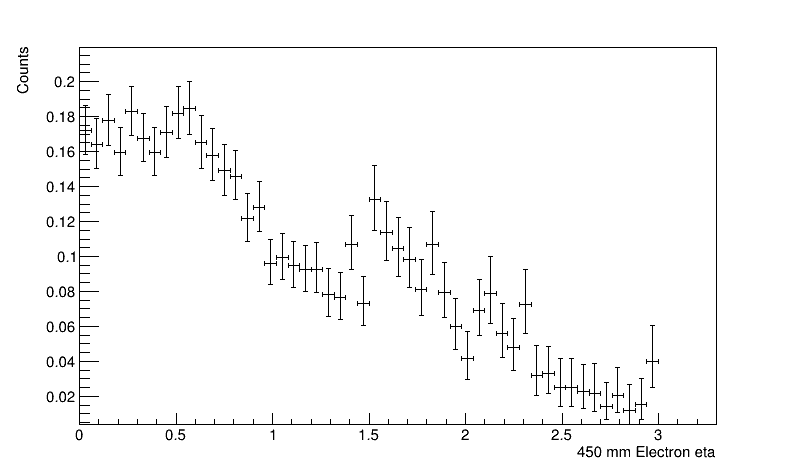

In [55]:
c1 = r.TCanvas('c1', '', 800, 500)
c1.cd()
eta_hists[3].Draw("AP")
c1.Draw()

In [56]:
A3D_axis = np.linspace(0, np.pi, 51)
A3D_hists = efficiency(fileName = "A3D",
                                plotVariable = "A3D",
                                plotAxis = [A3D_axis], 
                                plotxlabel = "Electron 3D Angle",
                                singleVar = True)

TypeError: Template method resolution failed:
  none of the 4 overloaded methods succeeded. Full details:
  ROOT::RDF::RResultPtr<TH1D> ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void>::Histo1D(basic_string_view<char,char_traits<char> > vName) =>
    TypeError: takes at most 1 arguments (2 given)
  ROOT::RDF::RResultPtr<TH1D> ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void>::Histo1D(const ROOT::RDF::TH1DModel& model, basic_string_view<char,char_traits<char> > vName, basic_string_view<char,char_traits<char> > wName) =>
    TypeError: takes at least 3 arguments (2 given)
  ROOT::RDF::RResultPtr<TH1D> ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void>::Histo1D(basic_string_view<char,char_traits<char> > vName, basic_string_view<char,char_traits<char> > wName) =>
    TypeError: could not convert argument 1
  ROOT::RDF::RResultPtr<TH1D> ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void>::Histo1D(const ROOT::RDF::TH1DModel& model = {"", "", 128U, 0., 0.}, basic_string_view<char,char_traits<char> > vName = "") =>
    runtime_error: Unknown column: "genParticle_A3D"
  none of the 4 overloaded methods succeeded. Full details:
  ROOT::RDF::RResultPtr<TH1D> ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void>::Histo1D(basic_string_view<char,char_traits<char> > vName) =>
    TypeError: takes at most 1 arguments (2 given)
  ROOT::RDF::RResultPtr<TH1D> ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void>::Histo1D(const ROOT::RDF::TH1DModel& model, basic_string_view<char,char_traits<char> > vName, basic_string_view<char,char_traits<char> > wName) =>
    TypeError: takes at least 3 arguments (2 given)
  ROOT::RDF::RResultPtr<TH1D> ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void>::Histo1D(basic_string_view<char,char_traits<char> > vName, basic_string_view<char,char_traits<char> > wName) =>
    TypeError: could not convert argument 1
  ROOT::RDF::RResultPtr<TH1D> ROOT::RDF::RInterface<ROOT::Detail::RDF::RJittedFilter,void>::Histo1D(const ROOT::RDF::TH1DModel& model = {"", "", 128U, 0., 0.}, basic_string_view<char,char_traits<char> > vName = "") =>
    runtime_error: Unknown column: "genParticle_A3D"
  Failed to instantiate "Histo1D(ROOT::RDF::TH1DModel*,std::string)"

In [ ]:
c1 = r.TCanvas('c1', '', 800, 500)
c1.cd()
A3D_hists[0].Draw("AP")
c1.Draw()

In [ ]:
c1 = r.TCanvas('c1', '', 800, 500)
c1.cd()
A3D_hists[1].Draw("AP")
c1.Draw()

In [ ]:
c1 = r.TCanvas('c1', '', 800, 500)
c1.cd()
A3D_hists[2].Draw("AP")
c1.Draw()

In [ ]:
c1 = r.TCanvas('c1', '', 800, 500)
c1.cd()
A3D_hists[3].Draw("AP")
c1.Draw()

In [ ]:
pt_axis = np.linspace(0, 6, 51)

hsig25mm_lowPtElectron_pt = getHistogram(dataframe = signal25mm_rdf_Di,
                                     variable = "lowPtElectron_pt",
                                     axis = pt_axis,
                                     xlabel = "Electron pT (GeV)") 

hsig250_lowPTElectrion_pt = getHistogram(dataframe = signal250mm_rdf_Di,
                                      variable = "lowPtElectron_pt",
                                      axis = pt_axis,
                                      xlabel = "Electrion pT (GeV)") 

hsig45_lowPTElectrion_pt = getHistogram(dataframe = signal45mm_rdf_Di,
                                      variable = "lowPtElectron_pt",
                                      axis = pt_axis,
                                      xlabel = "Electrion pT (GeV)") 

hsig450_lowPTElectrion_pt = getHistogram(dataframe = signal450mm_rdf_Di,
                                      variable = "lowPtElectron_pt",
                                      axis = pt_axis,
                                      xlabel = "Electrion pT (GeV)") 


plot = plotHistograms(name = "lowPtElectron_pt", 
               histos = [hsig25mm_lowPtElectron_pt, hsig250_lowPTElectrion_pt,hsig45_lowPTElectrion_pt,hsig450_lowPTElectrion_pt], 
               bins = pt_axis, 
               labels = ["Signal 25 mm", "Signal 250 mm", "Signal 45 mm", "Signal 450 mm"], 
               isstack = False,
               isnorm = True, 
               ylog=False,
               xlog=False)

In [ ]:
phi_axis = np.linspace(-np.pi-1, np.pi+1, 51)

Phi_hists = [0,0,0,0]

Phi_hists[0] = getHistogram(dataframe = signal25mm_rdf_Di,
                                     variable = "lowPtElectron_phi",
                                     axis = phi_axis,
                                     xlabel = "Electron phi (Rad)") 

Phi_hists[1] = getHistogram(dataframe = signal250mm_rdf_Di,
                                      variable = "lowPtElectron_phi",
                                      axis = phi_axis,
                                      xlabel = "Electron phi (Rad)") 

Phi_hists[2] = getHistogram(dataframe = signal45mm_rdf_Di,
                                      variable = "lowPtElectron_phi",
                                      axis = phi_axis,
                                      xlabel = "Electron phi (Rad)") 

Phi_hists[3] = getHistogram(dataframe = signal450mm_rdf_Di,
                                      variable = "lowPtElectron_phi",
                                      axis = phi_axis,
                                      xlabel = "Electron phi (Rad)") 


plot = plotHistograms(name = "lowPtElectron_phi", 
               histos = [Phi_hists[0], Phi_hists[1], Phi_hists[2], Phi_hists[3]], 
               bins = phi_axis, 
               labels = ["Signal 25 mm", "Signal 250 mm", "Signal 45 mm", "Signal 450 mm"], 
               isstack = False,
               isnorm = True, 
               ylog=False,
               xlog=False)


plot = plotHistograms(name = "lowPtElectron_phi", 
               histos = [Phi_hists[0], Phi_hists[1]], 
               bins = phi_axis, 
               labels = ["Signal 25 mm", "Signal 250 mm"], 
               isstack = False,
               isnorm = True, 
               ylog=False,
               xlog=False)

plot = plotHistograms(name = "lowPtElectron_phi", 
               histos = [Phi_hists[2], Phi_hists[3]], 
               bins = phi_axis, 
               labels = ["Signal 45 mm", "Signal 450 mm"], 
               isstack = False,
               isnorm = True, 
               ylog=False,
               xlog=False)

In [ ]:
phi_axis = np.linspace(-np.pi-1, np.pi+1, 51)

phi_hists = fourHistograms(fileName = "lowPtElectron_phi",
                                plotVariable = "lowPtElectron_phi",
                                plotAxis = phi_axis, 
                                plotxlabel = "Electron phi")

In [ ]:
dB_axis = np.linspace(0,10, 51)

dB_hists = fourHistograms(fileName = "lowPtElectron_dB",
                                plotVariable = "lowPtElectron_dB",
                                plotAxis = dB_axis, 
                                plotxlabel = "Electron Dxy (cm)",
                                plotSelection = "lowPtElectron_et > 10")

In [ ]:
dBsig_axis = np.linspace(0, 200, 51)

dB_hists = fourHistograms(fileName = "dBSig",
                                plotVariable = "dBSig",
                                plotAxis = dBsig_axis, 
                                plotxlabel = "Electron Dxy Significance (cm)",
                                plotSelection = "lowPtElectron_et > 10")

In [ ]:
DR_axis = np.linspace(0, 6, 51)

DR_hists = fourHistograms(fileName = "Delta_R",
                                plotVariable = "Delta_R",
                                plotAxis = DR_axis, 
                                plotxlabel = "Electron Delta R")

In [ ]:
delta_eta_axis = np.linspace(0, 6, 51)

D_eta_hists = fourHistograms(fileName = "Delta_eta",
                                plotVariable = "Delta_eta",
                                plotAxis = delta_eta_axis, 
                                plotxlabel = "Electron Delta eta")

In [ ]:
dm_axis = np.linspace(0, 350, 51)

dm_hists = fourHistograms(fileName = "Dielectron_mass",
                                plotVariable = "Dielectron_mass",
                                plotAxis = dm_axis, 
                                plotxlabel = "Dielectron mass (Gev)")

In [ ]:
A3D_axis = np.linspace(0, np.pi, 51)

'''A3D_hists = fourHistograms(fileName = "Electron_3d_angle",
                                plotVariable = "Electron_3d_angle",
                                plotAxis = A3D_axis, 
                                plotxlabel = "Electron 3D Angle",
                                Di = True)'''

In [ ]:
et_axis = np.linspace(1, 200, 51)

et_hists = fourHistograms(fileName = "lowPtElectron_et",
                                plotVariable = "lowPtElectron_et",
                                plotAxis = et_axis, 
                                plotxlabel = "Electron et",
                                plotSelection = "lowPtElectron_et > 10")

In [ ]:
time_axis = np.linspace(-10, 10, 51)

time_hists = fourHistograms(fileName = "lowPtElectron_seedTime",
                                plotVariable = "lowPtElectron_seedTime",
                                plotAxis = time_axis, 
                                plotxlabel = "Electron time",
                                plotSelection = "lowPtElectron_et > 10")

In [ ]:
time_hists_all = fourHistograms(fileName = "lowPtElectron_seedTime",
                                plotVariable = "lowPtElectron_seedTime",
                                plotAxis = time_axis, 
                                plotxlabel = "Electron time",
                                Di = False)

In [ ]:
time_hists_Lxy = fourHistograms(fileName = "lowPtElectron_seedTime",
                                plotVariable = "lowPtElectron_seedTime",
                                plotAxis = time_axis, 
                                plotxlabel = "Electron time",
                                Di = False,
                                plotSelection = "lowPtElectron_Lxy_SV > 0")

In [ ]:
hist_time25mm = histPairVsNot(fileName = "25mm_time",
                              plotDataframe = signal25mm_rdf, 
                              plotVariable = "lowPtElectron_seedTime",
                              plotAxis = time_axis, 
                              plotxlabel = "Electron time")

hist_time250mm = histPairVsNot(fileName = "250mm_time",
                              plotDataframe = signal250mm_rdf, 
                              plotVariable = "lowPtElectron_seedTime",
                              plotAxis = time_axis, 
                              plotxlabel = "Electron time")

In [ ]:
hist_time45mm = histPairVsNot(fileName = "45mm_time",
                              plotDataframe = signal45mm_rdf, 
                              plotVariable = "lowPtElectron_seedTime",
                              plotAxis = time_axis, 
                              plotxlabel = "Electron time")

hist_time450mm = histPairVsNot(fileName = "450mm_time",
                              plotDataframe = signal450mm_rdf, 
                              plotVariable = "lowPtElectron_seedTime",
                              plotAxis = time_axis, 
                              plotxlabel = "Electron time")

In [ ]:
Time_hists_Lxy = [0,0,0,0]

Time_hists_Lxy[0] = getHistogram(dataframe = signal25mm_rdf,
                                      variable = "lowPtElectron_seedTime",
                                      axis = time_axis,
                                      xlabel = "Electron Time (With high LxySV)",
                                      selection = "lowPtElectron_Lxy_SV > 1.0") 

Time_hists_Lxy[1] = getHistogram(dataframe = signal250mm_rdf,
                                      variable = "lowPtElectron_seedTime",
                                      axis = time_axis,
                                      xlabel = "Electron Time (With high LxySV)",
                                      selection = "lowPtElectron_Lxy_SV > 1.0") 

Time_hists_Lxy[2] = getHistogram(dataframe = signal45mm_rdf,
                                      variable = "lowPtElectron_seedTime",
                                      axis = time_axis,
                                      xlabel = "Electron Time (With high LxySV)",
                                      selection = "lowPtElectron_Lxy_SV > 1.0") 

Time_hists_Lxy[3] = getHistogram(dataframe = signal450mm_rdf,
                                      variable = "lowPtElectron_seedTime",
                                      axis = time_axis,
                                      xlabel = "Electron Time (With high LxySV)",
                                      selection = "lowPtElectron_Lxy_SV > 1.0") 


plot = plotHistograms(name = "lowPtElectron_seedTime", 
               histos = [Time_hists_Lxy[0], Time_hists_Lxy[1], Time_hists_Lxy[2], Time_hists_Lxy[3]], 
               bins = time_axis, 
               labels = ["Signal 25 mm", "Signal 250 mm", "Signal 45 mm", "Signal 450 mm"], 
               isstack = False,
               isnorm = True, 
               ylog=False,
               xlog=False)


plot = plotHistograms(name = "lowPtElectron_seedTime", 
               histos = [Time_hists_Lxy[0], Time_hists_Lxy[1]], 
               bins = time_axis, 
               labels = ["Signal 25 mm", "Signal 250 mm"], 
               isstack = False,
               isnorm = True, 
               ylog=False,
               xlog=False)

plot = plotHistograms(name = "lowPtElectron_seedTime", 
               histos = [Time_hists_Lxy[2], Time_hists_Lxy[3]], 
               bins = time_axis, 
               labels = ["Signal 45 mm", "Signal 450 mm"], 
               isstack = False,
               isnorm = True, 
               ylog=False,
               xlog=False)

In [ ]:
Lxy_axis = np.linspace(0, 50, 51)

Lxy_hists = fourHistograms(fileName = "lowPtElectron_Lxy_SV",
                                plotVariable = "lowPtElectron_Lxy_SV",
                                plotAxis = Lxy_axis, 
                                plotxlabel = "Dielectron Lxy ")

In [ ]:
Lxy_axis = np.linspace(0, 50, 51)

Lxy_hists = fourHistograms(fileName = "lowPtElectron_Lxy_SV",
                                plotVariable = "lowPtElectron_Lxy_SV",
                                plotAxis = Lxy_axis, 
                                plotxlabel = "Dielectron Lxy",
                                plotSelection = "lowPtElectron_et > 5 & lowPtElectron_Lxy_SV > 0")

In [ ]:
Lxy_hists = fourHistograms(fileName = "lowPtElectron_Lxy_SV",
                                plotVariable = "lowPtElectron_Lxy_SV",
                                plotAxis = Lxy_axis, 
                                plotxlabel = "Dielectron Lxy",
                                plotSelection = "lowPtElectron_Lxy_SV > 2")

In [ ]:
dB_axis = np.linspace(0, 10, 51)
time_axis = np.linspace(-10, 10, 51)

h2dsig25mm_lowPtElectron_time_and_db = getHistogram2d(dataframe = signal25mm_rdf,
                                                variable = "lowPtElectron_dB", 
                                                variable2  = "lowPtElectron_seedTime", 
                                                xaxis = dB_axis,
                                                yaxis = time_axis,
                                                xlabel = "Dxy",
                                                ylabel = "Time",
                                                selection = "lowPtElectron_trackIso > 0")

Csig25 = r.TCanvas();
Csig25.cd()
r.gStyle.SetOptStat(0)
h2dsig25mm_lowPtElectron_time_and_db.Draw('COLZ');
Csig25.SaveAs('plots/h2dsig25_lowPtElectron_time_and_db.png')
Image(filename='plots/h2dsig25_lowPtElectron_time_and_db.png')

h2dsig250mm_lowPtElectron_time_and_db = getHistogram2d(dataframe = signal250mm_rdf,
                                                variable = "lowPtElectron_dB", 
                                                variable2  = "lowPtElectron_seedTime", 
                                                xaxis = dB_axis,
                                                yaxis = time_axis,
                                                xlabel = "Dxy",
                                                ylabel = "Time",
                                                selection = "lowPtElectron_trackIso > 0")

Csig250 = r.TCanvas();
Csig250.cd()
r.gStyle.SetOptStat(0)
h2dsig250mm_lowPtElectron_time_and_db.Draw('COLZ');
Csig250.SaveAs('plots/h2dsig250_lowPtElectron_time_and_db.png')
Image(filename='plots/h2dsig250_lowPtElectron_time_and_db.png')

h2dsig45mm_lowPtElectron_time_and_db = getHistogram2d(dataframe = signal45mm_rdf,
                                                variable = "lowPtElectron_dB", 
                                                variable2  = "lowPtElectron_seedTime", 
                                                xaxis = dB_axis,
                                                yaxis = time_axis,
                                                xlabel = "Dxy",
                                                ylabel = "Time",
                                                selection = "lowPtElectron_trackIso > 0")

Csig45 = r.TCanvas();
Csig45.cd()
r.gStyle.SetOptStat(0)
h2dsig45mm_lowPtElectron_time_and_db.Draw('COLZ');
Csig45.SaveAs('plots/h2dsig45_lowPtElectron_time_and_db.png')
Image(filename='plots/h2dsig45_lowPtElectron_time_and_db.png')

h2dsig450mm_lowPtElectron_time_and_db = getHistogram2d(dataframe = signal450mm_rdf,
                                                variable = "lowPtElectron_dB", 
                                                variable2  = "lowPtElectron_seedTime", 
                                                xaxis = dB_axis,
                                                yaxis = time_axis,
                                                xlabel = "Dxy",
                                                ylabel = "Time",
                                                selection = "lowPtElectron_trackIso > 0")

Csig450 = r.TCanvas();
Csig450.cd()
r.gStyle.SetOptStat(0)
h2dsig450mm_lowPtElectron_time_and_db.Draw('COLZ');
Csig450.SaveAs('plots/h2dsig450_lowPtElectron_time_and_db.png')
Image(filename='plots/h2dsig450_lowPtElectron_time_and_db.png')

In [ ]:
h2dsig25mm_lowPtElectron_time_and_lxy = getHistogram2d(dataframe = signal25mm_rdf,
                                                variable = "lowPtElectron_Lxy_SV", 
                                                variable2  = "lowPtElectron_seedTime", 
                                                xaxis = Lxy_axis,
                                                yaxis = time_axis,
                                                xlabel = "Lxy",
                                                ylabel = "Time",
                                                selection = "lowPtElectron_trackIso > 0")

Csig25 = r.TCanvas();
Csig25.cd()
r.gStyle.SetOptStat(0)
h2dsig25mm_lowPtElectron_time_and_lxy.Draw('COLZ');
Csig25.SaveAs('plots/h2dsig25_lowPtElectron_time_and_lxy.png')
Image(filename='plots/h2dsig25_lowPtElectron_time_and_lxy.png')

h2dsig250mm_lowPtElectron_time_and_lxy = getHistogram2d(dataframe = signal250mm_rdf,
                                                variable = "lowPtElectron_Lxy_SV", 
                                                variable2  = "lowPtElectron_seedTime", 
                                                xaxis = Lxy_axis,
                                                yaxis = time_axis,
                                                xlabel = "Lxy",
                                                ylabel = "Time",
                                                selection = "lowPtElectron_trackIso > 0")

Csig250 = r.TCanvas();
Csig250.cd()
r.gStyle.SetOptStat(0)
h2dsig250mm_lowPtElectron_time_and_lxy.Draw('COLZ');
Csig250.SaveAs('plots/h2dsig250_lowPtElectron_time_and_lxy.png')
Image(filename='plots/h2dsig250_lowPtElectron_time_and_lxy.png')

In [ ]:
h2dsig45mm_lowPtElectron_time_and_lxy = getHistogram2d(dataframe = signal45mm_rdf,
                                                variable = "lowPtElectron_Lxy_SV", 
                                                variable2  = "lowPtElectron_seedTime", 
                                                xaxis = Lxy_axis,
                                                yaxis = time_axis,
                                                xlabel = "Lxy",
                                                ylabel = "Time")

Csig45 = r.TCanvas();
Csig45.cd()
r.gStyle.SetOptStat(0)
h2dsig45mm_lowPtElectron_time_and_lxy.Draw('COLZ');
Csig45.SaveAs('plots/h2dsig45_lowPtElectron_time_and_lxy.png')
Image(filename='plots/h2dsig45_lowPtElectron_time_and_lxy.png')

h2dsig450mm_lowPtElectron_time_and_lxy = getHistogram2d(dataframe = signal450mm_rdf,
                                                variable = "lowPtElectron_Lxy_SV", 
                                                variable2  = "lowPtElectron_seedTime", 
                                                xaxis = Lxy_axis,
                                                yaxis = time_axis,
                                                xlabel = "Lxy",
                                                ylabel = "Time")

Csig450 = r.TCanvas();
Csig450.cd()
r.gStyle.SetOptStat(0)
h2dsig450mm_lowPtElectron_time_and_lxy.Draw('COLZ');
Csig450.SaveAs('plots/h2dsig450_lowPtElectron_time_and_lxy.png')
Image(filename='plots/h2dsig450_lowPtElectron_time_and_lxy.png')